# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pyvisa # control gpib, tcp/ip etc...
import nidaqmx # Control ni-usb-6002
import paramiko
from scp import SCPClient   
import os
from matplotlib.animation import FuncAnimation
from itertools import count
import cv2
import natsort
import scipy
import lmfit

######### Module for c++
# import clr
# from System import Decimal

# for APT control of thorlab stages
from pylablib.devices import Thorlabs

# After rm_listsource does not show USB's....This is a longer way to take control over PM160
from ctypes import cdll,c_long, c_ulong, c_uint32,byref,create_string_buffer,c_bool,c_char_p,c_int,c_int16,c_double, sizeof, c_voidp
from TLPM import TLPM # TLPM.py is required

# Instruments

In [2]:
rm = pyvisa.ResourceManager()

In [3]:
rm.list_resources()

('USB0::0x1313::0x807B::16041103::INSTR',
 'TCPIP0::192.168.0.2::inst0::INSTR',
 'ASRL1::INSTR',
 'ASRL4::INSTR',
 'ASRL5::INSTR',
 'ASRL6::INSTR',
 'ASRL7::INSTR',
 'GPIB0::17::INSTR',
 'GPIB0::19::INSTR',
 'GPIB0::24::INSTR')

In [7]:
# load RHODE SCHWARZ microwave
smf100a=rm.open_resource('TCPIP::192.168.0.2::hislip0::INSTR');time.sleep(0.5) 
# smf100a.write('SOUR:LFO1:SHAP:PULS:WIDT %.10f'%wid)
# smf100a.write('SOUR:LFO1:SHAP:PULS:PER %.10f'%peri)

#load ghost
ghost=rm.open_resource('TCPIP::localhost::4000::SOCKET');time.sleep(1)
ghost.read_termination='\r\n';time.sleep(1)

# load kepco
kepco=rm.open_resource('GPIB0::6::INSTR');time.sleep(0.5)

sr830a=rm.open_resource('GPIB0::17::INSTR');time.sleep(0.5)
sr830b=rm.open_resource('GPIB0::19::INSTR');time.sleep(0.5)
# load PSP
PSP603= rm.open_resource('ASRL5::INSTR', baud_rate=2400);time.sleep(0.1)
PSP603.read_termination='\r\n';time.sleep(0.1)
PSP603.write("KOE");time.sleep(0.1) # Output ON
PSP603.write("SI 1.0");time.sleep(0.1)# Set current limit to 0.9 A
    
# laser power meter NI_VISA
thorlabsPM16=rm.open_resource("USB0::0x1313::0x807B::16041103::0::INSTR");time.sleep(0.5) # load U2002H power meter
thorlabsPM16.write('CONF:POW');time.sleep(0.2)  # change to power measure mode

# Tesla meter
f41=rm.open_resource('ASRL8::INSTR',baud_rate=115200,write_termination='\r\n',read_termination='\r\n');time.sleep(1) 

# Torus 532
Torus532 = rm.open_resource('ASRL6::INSTR',baud_rate=19200,write_termination = '\r\n',read_termination = '\r\n')

####### Keysight 2962A
key2962A=rm.open_resource('GPIB0::23::INSTR');time.sleep(1)
key2962A.write('INIT')
key2962A.write(':SOUR:CURR:MODE FIX')
key2962A.write('CURR 0e-3')
# key2962A.query('MEAS:VOLT?')
key2962A.write(':SENS:VOLT:PROT 0.1')
key2962A.write('OUTP1 ON')

######################### ag34401a
# ag34401a=rm.open_resource('GPIB0::25::INSTR');time.sleep(0.5)
# ag34420a=rm.open_resource('GPIB0::22::INSTR');time.sleep(0.5)
############# PM160 TLPM library
# tlPM = TLPM()
# deviceCount = c_uint32()
# tlPM.findRsrc(byref(deviceCount))
# print("devices found: " + str(deviceCount.value))
# resourceName = create_string_buffer(1024)
# tlPM.getRsrcName(c_int(0), resourceName)
# tlPM.open(resourceName, c_bool(True), c_bool(True))

#########################k2636A############
# k2636a=rm.open_resource('GPIB0::26::INSTR')
# k2636a.write('smua.source.func=0')
# k2636a.write('smua.source.leveli=1e-3')
# k2636a.write('smua.source.limitv = 20')
# k2636a.write('smua.measure.rangev = 10 ')
# k2636a.write('smua.source.output = 1 ')
# k2636a.write('print(smua.measure.v())')
# vals=k2636a.read()
# k2636a.write('smua.source.output = 0 ')
# print(vals)

# User defined functions

In [8]:
##############################   kepco  ########################################         
def init_kepco_local():
    kepco.write('FUNC:MODE CURR')
    kepco.write('CURR 0.00000')
    kepco.write('OUTP ON')
    return

def change_curr_local(curr):
    kepco.write('CURR %.4f'%curr)
    return

##############################   PSP  ######################################## 
def change_volt_PSP(volt):
    PSP603.write('SV %.2f'%volt);
    return volt

def PSP_seq_volt(volt):
    tlist=np.linspace(0,5,100)
    vlist=volt+volt*np.sin(tlist*2*np.pi/0.2)*np.exp(-tlist**2/3)
    tstep=(tlist[1]-tlist[0])
    print('PSP voltage stablization is running...')
    for i,v in enumerate(vlist):
        change_volt_PSP(v);time.sleep(tstep)

##############################   lockin  ######################################## 
def getAvg(sens):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2") # dev2 is multi-purpose ni-daq card: AI2=x & AI3=y
#         task.timing.cfg_samp_clk_timing(1000)
        data=task.read(number_of_samples_per_channel=1024)
        return np.mean(data[800:])*sens/10.0 # sens in mV
def getAvgY(sens):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3") # dev2 is multi-purpose ni-daq card: AI2=x & AI3=y
#         task.timing.cfg_samp_clk_timing(1000)
        data=task.read(number_of_samples_per_channel=1024)
        return np.mean(data[800:])*sens/10.0 # sens in mV
    
def getAvg_GPIB(i):
    return float(sr830a.query('OUTP? %i'%i).split('\n')[0])

def getAvg_GPIB_TRAC():
    sr830a.write('REST')
    sr830a.write('STRD')
    time.sleep(1)
    return np.mean([float(x) for x in sr830a.query('TRCA? 1,0,20').split(',')[:-1]])    
# second lockin for Pt voltage
def getlock2x(sens):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4") # dev2 is multi-purpose ni-daq card: AI2=x & AI3=y
#         task.timing.cfg_samp_clk_timing(1000)
        data=task.read(number_of_samples_per_channel=1024)
        return np.mean(data[800:])*sens/10.0 # sens in mV
    
def getlock2y(sens):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5") # dev2 is multi-purpose ni-daq card: AI2=x & AI3=y
#         task.timing.cfg_samp_clk_timing(1000)
        data=task.read(number_of_samples_per_channel=1024)
        return np.mean(data[800:])*sens/10.0 # sens in mV
    
def adjust_sens():
    senslist=np.array([2e-6,5e-6,10e-6,20e-6,50e-6,100e-6,200e-6,500e-6,1e-3,2e-3,5e-3,10e-3,20e-3,50e-3,100e-3,200e-3,500e-3,\
                  1,2,5,10,20,50,100,200,500,1000])
    
    init_sens=14 # 16 = 0.1 mV
    sr830a.write('SENS %i'%(init_sens))
    print(f'Sens is adjusted to {senslist[init_sens]} mV...')
    time.sleep(0.1)
    i=0
    while float(sr830a.query('LIAS? 2').split('\n')[0])==1:
        i=i+1
        sr830a.write('SENS %i'%(init_sens+i))
        print(f'Sens is adjusted to {senslist[init_sens+i]} mV...')
        time.sleep(0.1)
#         float(sr830a.query('LIAS? 2').split('\n')[0])#clear bit 2
    sr830a.write('SENS %i'%(init_sens+i+1))
    print(f'Sens is adjusted to {senslist[init_sens+i+1]} mV...')
    time.sleep(0.1)
    return senslist[init_sens+i+1]    

##############################   microwave  ######################################## 
def change_power(power):
    smf100a.write('SOUR:POW %.10f'%power)
    return

def turnMW_on_off(control):
    smf100a.write("OUTP:All %s"%control)
    return

def change_freq(freq):
    smf100a.write('SOUR:FREQ %.10f'%freq)
    return freq

def change_mod(control):
    smf100a.write('SOUR:Mod %s'%control)
    return

def init_LFO():               
    smf100a.write('SOUR:LFO1:VOLT %.10f'%2.5) # 2.5 is good for simulating TTL for lockin ref
    smf100a.write('SOUR:LFO1 ON')
    smf100a.write('SOUR:LFO1:OFFS 0')
def set_LFO_pulse(wid,peri):   
    
    smf100a.write('SOUR:LFO1:SHAP:PULS:WIDT %.10f'%wid)
    smf100a.write('SOUR:LFO1:SHAP:PULS:PER %.10f'%peri)
    
##############################   file i/o  ######################################## 
def save_header(pfile, outputfile, header, flag='w') :
    with open(pfile) as fp:
        content = fp.readlines()
        fp.close()
    with open(outputfile, flag) as fp:
        for line in content:
            print('#', line[:-1], file=fp)
        if flag == 'w': print('#', header, file=fp)
        fp.close()
    return
    
def stopper(pfile):
    with open(pfile) as fp:
        content = fp.readlines()
        fp.close()
    return content[0].split('\n')[0]

def read_linenum(pfile):
    with open(pfile) as fp:
        content = fp.readlines()
        fp.close()
        i=0
        while len(content[-i-1].split('::::'))==1:
            i=i+1
    return int(content[-i-2].split(':')[0])

##############################   ghost  ######################################## 
def check_ghost_acquiring(sweepcount,BLScount):
    global error_occured
    error_occured=0
    status='Template:  on'
    while status.split(':')[1].split('on')[0]!=' IDLE ':
        ghost.clear();time.sleep(0.1)
        ghost.write("status");time.sleep(0.1)
        for i in range(2):
            status=ghost.read('\n');time.sleep(0.1)
            print('%i: %s'%(i,status))

        if len(status.split(':'))==1:
            print('Status returned null...') # Emergency reset
            print('ghost message is %s'%status)
            ghost.clear();time.sleep(1);print('clear requested')
            ghost.write('stop');time.sleep(1);print('stop requested')
            ghost.write('restore');time.sleep(1);print('resotred')
            ghost.write('override');time.sleep(3);print('overrode')
            ghost.clear();time.sleep(1);print('2nd clear requested')
            ghost.write('delete');time.sleep(0.1);print('delete requested')
#             for i in range(1):
#                 status=ghost.read('\n');time.sleep(0.1)
#                 print('%i: %s'%(i,status))
            ghost.write('stop');time.sleep(1);print('stop requested')
            ghost.write('delete');time.sleep(0.1);print('delete requested')
            ghost.clear();time.sleep(1);print('clear requested')
            ghost.write('delete');time.sleep(1);print('delete requested')
            ghost.write('start %i'%BLScount);time.sleep(1)
            print('starting scan number %i again...'%sweepcount)
            status='Template:  on'
            error_occured=error_occured+1
            
        if len(status.split('<infinite>'))==2:
            print('Status entered infinity loop...') 
            ghost.clear();time.sleep(1);print('clear requested')
            ghost.write('stop');time.sleep(1);print('stop requested')
            ghost.write('restore');time.sleep(1);print('resotred')
            ghost.write('override');time.sleep(3);print('overrode')
            ghost.clear();time.sleep(1);print('2nd clear requested')
            ghost.write('delete');time.sleep(1);print('delete requested')
            ghost.write('start %i'%BLScount);time.sleep(0.1)
            print('starting scan number %i again...'%sweepcount)
            status='Template:  on'
            error_occured=error_occured+1
        else:
            pass
    return error_occured

def get_zerodata(month,fname):
    motherpath='D:/Jupyter_notebooks/Kyongmo/'
    path=motherpath+month+'/'+'BLS_'+fname+'/'
    files=natsort.natsorted(os.listdir(path))
    data=np.loadtxt(path+files[0],skiprows=12)
    return data[len(data)//2]
def get_latestdata(month,fname):
    motherpath='D:/Jupyter_notebooks/Kyongmo/'
    path=motherpath+month+'/'+'BLS_'+fname+'/'
    files=natsort.natsorted(os.listdir(path))
    data=np.loadtxt(path+files[-1],skiprows=12)
    return data[len(data)//2]

def get_BLS_Singleshot_counts(fname,month):
#     ghost.write('wdir D:/Jupyter_notebooks/Kyongmo/2304/BLS_%s'%fname);time.sleep(0.1)
    ghost.write('delete');time.sleep(0.1)
    ghost.write('start %i'%1);#time.sleep(90/100*BLScount)
    error_occured=check_ghost_acquiring(1,1);time.sleep(0.1)
    ghost.write('stop');time.sleep(0.1)
    ghost.write('save BLS_singleshot.dat');time.sleep(0.1)
    
    motherpath='D:/Jupyter_notebooks/Kyongmo/'
    path=motherpath+month+'/'+'BLS_'+fname+'/'
    data=np.loadtxt(path+'BLS_singleshot.dat',skiprows=12)
    return np.sum(data[0:len(data)//4])

def BLS_maximizer(test_freq,test_power):
    nscan=5
    nhalf=nscan//2
    stagex.move_by(int(-nhalf*2180));time.sleep(1) #2180 is 1 um
    stagey.move_by(int(-nhalf*2180));time.sleep(1)
    xc,yc,zi=np.zeros((3,nscan,nscan))
    x0=stagex.get_position()
    y0=stagey.get_position()
    
    change_freq(test_freq)
    change_power(test_power)
    for i in range(nscan):
        if i==0:
            pass
        else:
            stagey.move_to(int(y0));
            stagex.move_by(int(2180));
        for j in range(nscan):
            if j==0:
                pass
            else:
                stagey.move_by(int(2180))
            tdata=get_BLSinten(fname,'2304')
            xc[i,j]=stagex.get_position()
            yc[i,j]=stagey.get_position()
            zi[i,j]=get_BLS_Singleshot_counts(fname,'2304')
            print('x=%.0f,y=%.0f,Total count=%.0f'%(xc[i,j],yc[i,j],zi[i,j]))
    max_index = np.argmax(zi)
    max_index_tuple = np.unravel_index(max_index, zi.shape)
    print('drift correction finished')
    maxpos=xc[max_index_tuple],yc[max_index_tuple]
    print('Max total: %.0f at x=%.0f,y=%.0f'%(zi[max_index_tuple],maxpos[0],maxpos[1]))
    stagex.move_to(int(maxpos[0]))
    stagey.move_to(int(maxpos[1]))
    print('moved to the max BLS intensity position')
    print('return to the original power: %.3f dBm'%power)
    change_power(power)
    os.remove('BLS_singleshot.dat')
    os.remove('test123.dat')
##############################   xy stage  ########################################            
def init_stage():
    ks.TLI_BuildDeviceList();time.sleep(0.5) #initialize
    ks.TLI_GetDeviceListSize();time.sleep(0.5)
    
    serialnox = c_char_p(bytes("26001463", "utf-8"))
    serialnoy = c_char_p(bytes("26001408", "utf-8"))
    
    ks.SCC_Open(serialnox);time.sleep(0.1)
    ks.SCC_Open(serialnoy);time.sleep(0.1)
    return serialnox,serialnoy

cfactor=4.577e-07
def get_posx():
    xstep=ks.SCC_GetPosition(serialnox)    
    xmm=cfactor*(xstep+3020209)-1.3825
    return xmm

def move_posx(xmm):
    xstep=(xmm+1.3825)/cfactor-3020209
    ks.SCC_MoveToPosition(serialnox, int(xstep))

def get_posy():
    ystep=ks.SCC_GetPosition(serialnoy)    
    ymm=cfactor*(ystep-1447199)+0.6625
    return ymm

def move_posy(ymm):
    ystep=(ymm-0.6625)/cfactor+1447199
    ks.SCC_MoveToPosition(serialnoy, int(ystep))
    
##############################   camera  ######################################## 
def takepic(picture_name):
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    out = cv2.imwrite(picture_name, frame)
    time.sleep(0.5)
    cap.release()
    cv2.destroyAllWindows()
    
##############################   laser  ######################################## 
def get_powerNOW():
    thorlabsPM16.write('READ?');time.sleep(0.1)
    powerNOW=1e3*float(thorlabsPM16.read().split()[0])
    return powerNOW

def get_powerTLPM():
    l_power =  c_double()
    tlPM.measPower(byref(l_power))
    return float(l_power.value)*1e3

def setTorus(percent):
    if 29<percent<96:
        Torus532.write('CURRENT=%.2f'%percent);time.sleep(0.2)
    else:
        print('Request power is out of range!')
        
def AdjustTorus(power_requested,initial_percent,step):
    global laser_percent
    i=0
    setTorus(initial_percent)
    if get_powerNOW()<power_requested:
        while get_powerNOW()<power_requested:
            setTorus(initial_percent+i*step);time.sleep(0.1)
            i=i+1
            print(f'Laser power is {get_powerNOW()} @ {initial_percent+i*step} percents');
            laser_percent=initial_percent+i*step
            
    else:
        while get_powerNOW()>power_requested:
            setTorus(initial_percent-i*step);time.sleep(0.1)
            i=i+1
            print(f'Laser power is {get_powerNOW()} @ {initial_percent-i*step} percents');
            laser_percent=initial_percent-i*step
    return laser_percent

##############################   z stage  ######################################## 

def move2field(desired_field,step,calfactor):
    #calfactor=324.94/251.63
    current_field=float(f41.query('FETCh:DC?'))*1e3*calfactor # in mT
    if desired_field<current_field:
        while desired_field<current_field:
            stagez.move_by(int(step))
            time.sleep(0.1)
            while stagez.is_moving()==1:
                print('waiting for stop...')
                time.sleep(1)
                print(f'Z-stage is now at {stagez.get_position()}.')
                time.sleep(0.1)
                current_field=float(f41.query('FETCh:DC?'))*1e3*calfactor
                print(f'current field is {current_field} mT')
    else:
        while desired_field>current_field:
            stagez.move_by(int(-step))
            time.sleep(0.1)
            print()
            while stagez.is_moving()==1:
                print('waiting for stop...')
                time.sleep(1)
                print(f'Z-stage is now at {stagez.get_position()}.')
                time.sleep(0.1)
                current_field=float(f41.query('FETCh:DC?'))*1e3*calfactor
                print(f'current field is {current_field} mT')

def move2field_senis(desired_field,step,calfactor):
    #calfactor=324.94/251.63
    current_field=float(measureSenis())*1e0*calfactor # in mT
    if desired_field<current_field:
        while desired_field<current_field:
            stagez.move_by(int(step))
            time.sleep(0.1)
            while stagez.is_moving()==1:
                print('waiting for stop...')
                time.sleep(1)
                print(f'Z-stage is now at {stagez.get_position()}.')
                time.sleep(0.1)
                current_field=float(measureSenis())*1e0*calfactor
                print(f'current field is {current_field} mT')
    else:
        while desired_field>current_field:
            stagez.move_by(int(-step))
            time.sleep(0.1)
            print()
            while stagez.is_moving()==1:
                print('waiting for stop...')
                time.sleep(1)
                print(f'Z-stage is now at {stagez.get_position()}.')
                time.sleep(0.1)
                current_field=float(measureSenis())*1e0*calfactor
                print(f'current field is {current_field} mT')                
########################################### Senis ##################
def measureSenis():
    scp.SCPClient(conRPi.get_transport()).put('MeasureKM.py','/home/pi/software/threeDhall_sw');time.sleep(0.3)
    stdin,stdout,stderr=conRPi.exec_command('python3 /home/pi/software/threeDhall_sw/MeasureKM.py');time.sleep(1)
    scp.SCPClient(conRPi.get_transport()).get('/home/pi/software/threeDhall_sw/bzfield.dat')
    time.sleep(0.3)
    bx,by,bz,temphall=np.loadtxt('bzfield.dat')
#     print(bx,by,bz,temphall)
    return bz


############ Lockin control


header="0:Power\t 0:RF \t 2:Curr(A)\t 3:Freq \t 4:sX (V) \n"    

# Stage initilization

In [9]:
Thorlabs.list_kinesis_devices()

[('26001408', 'Stepper Controller'),
 ('97101351', 'Kinesis Pz Motor Control'),
 ('26001463', 'Stepper Controller')]

In [10]:
################# APT control of stages
# Thorlabs.list_kinesis_devices()

stagex = Thorlabs.KinesisMotor("26001463")
stagey = Thorlabs.KinesisMotor("26001408")
stagez = Thorlabs.KinesisPiezoMotor("97101351")

############### Kinesis control for xy stages
# serialnox,serialnoy=init_stage()

# # get current x position
# current_motor_posx = ks.SCC_GetPosition(serialnox)
# print("Current position x:", current_motor_posx)

# # get current y position
# current_motor_posy = ks.SCC_GetPosition(serialnoy)
# print("Current position y:", current_motor_posy)

print(r'10000 step is about %.4f um'%(4.6))

10000 step is about 4.6000 um


# Single-shot commands

## Stage operations

In [21]:
stagez.setup_drive(velocity=1200,acceleration=1200)

TPZMotorDriveParams(max_voltage=112, velocity=1200, acceleration=1200)

In [59]:
stagez.move_by(-50)

## Microwave

In [11]:
turnMW_on_off('ON')

In [59]:
change_mod('ON')

In [13]:
change_power(24)

In [12]:
change_freq(4.8e9)

4800000000.0

## Local control ghost

In [731]:
ghost.write('restore');time.sleep(1) 

## Local control kepco

In [27]:
init_kepco_local()  

In [24]:
change_curr_local(3)

# <font color='blue'>Measure micro-BLS</font>

## Freq sweep first

In [ ]:
print('First_line_identifier::::should be kept here')
print('Sample :YIGDISK')
######################## Set parameters
fname='230503a9_YigdiskShort_BLS_FreqXYsweep_19dBAtt_12dBm_3A_0V'
curr_list=np.linspace(3,3,1)
volt_list=np.linspace(0,0,1)
freq_list=np.linspace(5.95e9,6.15e9,50)
# freq_list=np.linspace(5.1e9-60e6,5.1e9+10e6,1000)
power_list=np.array([12])
# power_list=np.linspace(0.01,1,10) # in mW
# power_list=10*np.log10(power_list)
# posz_list=np.concatenate((np.linspace(1000,1000,7),np.linspace(100,100,6),np.linspace(25,25,124),\
#                           np.linspace(100,100,7),np.linspace(1000,1000,6)))
hz_list=np.linspace(0,0,1) #
posy_list=np.linspace(2180*15,2180*15,5) # cal: 1000 step = 0.5 um
posx_list=np.linspace(2180*15,2180*15,15) # better accuracy: 2140 = 1 um
laserpower_list=np.linspace(10,10,1)
modfreq_list=np.linspace(3177,3177,1)
ptcurr_list=np.linspace(0,0,1)
# pulse_const=0.1e-3*3177*4
BLScount=1
calfactor=1
try:
    laser_percent
except NameError:
    print('laser_pecent is not defined and it is now 90!')
    laser_percent=84.3
percent_step=0.05 # default = 0.02
# laser_percent=84.3
sens=10 # in mV
sens2=20e-3 # in mV

###################### Set Directory
os.mkdir('D:/Jupyter_notebooks/Kyongmo/2304/BLS_%s'%fname)
ghost.write('override');time.sleep(3)
ghost.write('wdir D:/Jupyter_notebooks/Kyongmo/2304/BLS_%s'%fname)

###################### Save picture at starting position 
os.mkdir('D:/Jupyter_notebooks/Kyongmo/2304/Pictures/%s'%fname)
takepic('D:/Jupyter_notebooks/Kyongmo/2304/Pictures/%s/begin.png'%fname)

###################### Register time
time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

###################### Set swiches
sweepcount=1
dt=[]
error_occured=[]

#####################save codes
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')
get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

init_xpos=stagex.get_position()
init_ypos=stagey.get_position()
print('xpos is %.3f'%init_xpos)
print('ypos is %.3f'%init_ypos)

####################### Loop
try:
    for f0,modfreq in enumerate(modfreq_list):
        print('Mod freq is changing...')
#         set_LFO_pulse(pulse_const/modfreq,1/modfreq)
#         sr830a.write('FREQ %.4f'%modfreq)
        time.sleep(1)

        for k1,laserpower in enumerate(laserpower_list):
            print('Laser power adjustment is starting...')
            laser_percent_new=AdjustTorus(laserpower,laser_percent,percent_step)
            time.sleep(1)
            
            for s2,ptcurr in enumerate(ptcurr_list):
#                 key2962A.write('CURR %3f'%ptcurr)
                time.sleep(0.01)
                
                for k2,power in enumerate(power_list):
                    print('MW Power is changing...')
                    change_power(power)
                    time.sleep(1)

                    for j,curr in enumerate(curr_list):
                        print('Kepco current is changing...')
                        change_curr_local(curr)
                        time.sleep(0.5) # stablization of field

                        for n,volt in enumerate(volt_list):
                            print('PSP voltage is changing...')
    #                         if n==0:
    #                             PSP_seq_volt(volt_list[-1]) # remove hystresis
    #                             PSP_seq_volt(volt_list[0]) # remove hystresis
    #                         PSP_seq_volt(volt)
                            change_volt_PSP(volt)
                            time.sleep(1) # stablization of field

                            for m1,hz in enumerate(hz_list):
#                                 move2field(**dict(desired_field=hz,step=1000,calfactor=1))
                                time.sleep(0.1)

                                for m2,posx in enumerate(posx_list):
                                    if m2==0:
                                        pass
                                    else:
                                        stagey.move_to(int(init_ypos))
                                        print(f'x-stage is now at {stagex.get_position()}.')
                                        stagex.move_by(int(posx));time.sleep(1)
                                        time.sleep(1)
                                        while stagex.is_moving()==1:
                                            time.sleep(0.5)
                                            print('waiting for x-stage to stop...')
                                        time.sleep(1)
                                    
                                    for m3,posy in enumerate(posy_list):
                                        if m3==0:
                                            pass
                                        else:
                                            stagey.move_by(int(posy));time.sleep(1)
                                            print(f'y-stage is now at {stagey.get_position()}.')
                                            time.sleep(1)
                                            while stagey.is_moving()==1:
                                                time.sleep(0.5)
                                                print('waiting for y-stage to stop...')
                                            time.sleep(1)
                                        BLS_maximizer(6.065e9,18) # scan over 4 um x 4 um square to find max
                                        time.sleep(1)
                                        takepic('D:/Jupyter_notebooks/Kyongmo/2304/Pictures/%s/x=%i_y=%i.png'%(fname,m2,m3))
                                        
                                        for i,freq in enumerate(freq_list):
                                            time1=time.time()
                                            print('MW Freq is changing...')
                                            change_freq(freq)
                                            time.sleep(0.07)
        #                                     thorlabsPM16.write('READ?'); # read laser power
                                            lpowernow=get_powerNOW()
                                            ghost.write('delete');time.sleep(0.1)
                                            print('starting scan number %i...'%sweepcount)
                                            ghost.write('start %i'%BLScount);#time.sleep(90/100*BLScount)
                                            error_occured=check_ghost_acquiring(sweepcount,BLScount);time.sleep(0.1)
                                            ghost.write('stop');time.sleep(0.1)
                                            ghost.write('save %i.dat'%sweepcount);time.sleep(0.1)

                                            print('%i.dat created'%sweepcount)
                                            print('scan number %i finished.'%sweepcount)
                                            Ncol=19
                                            data_raw=np.zeros(Ncol)
                                            data_raw[0] = float(power)
                                            data_raw[1] = stagex.get_position()
                                            data_raw[2] = stagey.get_position()
                                            data_raw[3] = hz                   
                                            data_raw[4] = float(curr)
                                            data_raw[5] = float(freq)
                                            data_raw[6] = float((kepco.query('meas:curr?')).split('\n')[0]) #actual current
                                            data_raw[7] = float(getAvg(sens))#float(getAvg()) #lockin X voltage
                                            data_raw[8] = lpowernow
                                            data_raw[9] = float(volt) # PSP voltage output
                                            data_raw[10] = 0#float(f41.query('FETCh:DC?'))*1e3*1 # Field at the center in mT : 0.9172=calfactor
                                            data_raw[11] = float(laserpower) # laser power
                                            data_raw[12] = float(modfreq) # modulation 
                                            data_raw[13] = float(sens)
                                            data_raw[14] = float(time1) 
                                            data_raw[15] = float(error_occured)
                                            data_raw[16] = float(getlock2x(sens2))
                                            data_raw[17] = float(getlock2y(sens2))
                                            data_raw[18] = float(ptcurr)
                                            status=stopper('status.py')
                                            if status=='STOP':
                                                print('Measurement has been stopped')
                                                time.sleep(1)
                                                raise StopIteration

                                            data_arr=np.array([data_raw[0],data_raw[1],data_raw[2],\
                                                               data_raw[3],data_raw[4],data_raw[5],\
                                                               data_raw[6],data_raw[7],data_raw[8],\
                                                               data_raw[9],data_raw[10],data_raw[11],\
                                                               data_raw[12],data_raw[13],data_raw[14],\
                                                               data_raw[15],data_raw[16],data_raw[17],\
                                                              data_raw[18]])
                                            data = np.reshape(data_arr,(1,Ncol))
                                            if sweepcount==1:
                                                fp=open(fname+'.dat','a')
                                            else:
                                                pass
                                            np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
                                            fp.flush() # flush all buffer data to a file
                                            TotN=len(curr_list)*len(power_list)*len(freq_list)*len(posx_list)*len(posy_list)*len(hz_list)\
                                            *len(volt_list)*len(laserpower_list)*len(modfreq_list)*len(ptcurr_list)
                                            if sweepcount==TotN:
                                                fp.close()  
                                            print('MW Power: {} dBm, Pos x: {}, Pos y: {}, Pos z: {}, Kepco : {} A, MW freq : {} Hz, Laser Power: {} mW, Field : {}, Mod Freq : {}'.format(\
                                                    data_raw[0],data_raw[1],data_raw[2],data_raw[3], data_raw[6], data_raw[5],data_raw[8],data_raw[10],data_raw[12]))
                                            time2=time.time()
                                            dt.append((time2-time1)/60)
                                            dtmean=np.mean(dt)
                                            tleft=dtmean*(TotN-sweepcount)
                                            print('Time left : %.4f minutes'%(tleft))
                                            print('Completed scan %d out of %d'%(sweepcount,TotN))
                                            sweepcount=sweepcount+1
                                            
                                            ########## safety checks ##########
                                            # check laser power
                                            if (data_raw[8]>laserpower*1.005)|(data_raw[8]<laserpower*0.995):
                                                print('Laser power adjustment is starting...')
                                                laser_percent=AdjustTorus(laserpower,laser_percent,percent_step)
                                            
                                            # check scan stability
                                            zerodata=get_zerodata('2304',fname)
                                            latestdata=get_latestdata('2304',fname)
                                            if (latestdata>zerodata*1.5)|(latestdata<zerodata*0.5):
                                                print('Scan is unstable!')
                                                laser_percent=AdjustTorus(0.07,laser_percent,1)
                                                time.sleep(1)
                                                raise StopIteration
                                            else:
                                                print('Scan works fine!')
except StopIteration:
    fp.close()
    
###################### Save picture at ending position 
takepic('D:/Jupyter_notebooks/Kyongmo/2304/Pictures/%s/end.png'%fname)
##return to original posiiton
stagex.move_to(int(init_xpos))
stagey.move_to(int(init_ypos))
print('Total time elapsed %.3f mins'%((time2-time_start)/60))
ghost.write('restore');time.sleep(1)

## Posz sweep first

In [ ]:
print('First_line_identifier::::should be kept here')

######################## Set parameters
fname='220223t6-cc5-ms5-sr150-mwptgggyig-Pt-FB-ModOFF-hsweep-2freqs' #FB :focus bottom, FT: focus top, FM: focus middle
sens=500
curr_list=np.linspace(0,0,1)
volt_list=np.linspace(0,0,1)
freq_list=np.array([5.325e9,5.325e9+3.2e6/2])
power_list=np.array([24])
posz_list=np.concatenate((np.linspace(1000,1000,6),np.linspace(100,100,3),np.linspace(25,25,127),\
                          np.linspace(100,100,6),np.linspace(1000,1000,5)))
#posz_list=np.linspace(0,0,1) #
posy_list=np.linspace(0,0,1) # cal: 1000 step = 0.5 um
laserpower_list=np.linspace(10,10,1)
BLScount=5

calfactor=350/258.0265036621
laserpower=10
# laser_percent=85
percent_step=0.05 # default = 0.02

###################### Set Directory
os.mkdir('C:/Users/KRISS_BLS/kyongmo_jupyternotebooks/data/2202/BLS_%s'%fname)
ghost.write('override');time.sleep(3)
ghost.write('wdir C:/Users/KRISS_BLS/kyongmo_jupyternotebooks/data/2202/BLS_%s'%fname)

###################### Save picture at starting position 
os.mkdir('C:/Users/KRISS_BLS/kyongmo_jupyternotebooks/data/2202/Pictures/%s'%fname)
takepic('C:/Users/KRISS_BLS/kyongmo_jupyternotebooks/data/2202/Pictures/%s/begin.png'%fname)

###################### Register time
time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

###################### Set swiches
sweepcount=1
dt=[]
#####################save codes
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')
get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

######################### Set laser power
print('Laser power adjustment is starting...')
laser_percent=AdjustTorus(laserpower,laser_percent,percent_step)
    
####################### Loop
try:
    for k1,laserpower in enumerate(laserpower_list):
#         laser_percent=AdjustTorus(laserpower,laser_percent,percent_step)
#         time.sleep(1)
        
        for k2,power in enumerate(power_list):
            change_power(power)
            time.sleep(1)

            for j,curr in enumerate(curr_list):
#                 change_curr_local(curr)
                time.sleep(0.5) # stablization of field

                for n,volt in enumerate(volt_list):
#                     if n==0:
#                         PSP_seq_volt(volt_list[-1]) # remove hystresis
#                         PSP_seq_volt(volt_list[0]) # remove hystresis
#                     PSP_seq_volt(volt)
                    change_volt_PSP(volt)
                    time.sleep(1) # stablization of field
        
                    for i,freq in enumerate(freq_list):
                        move2field(**dict(desired_field=360,step=5000,calfactor=calfactor))
                        move2field(**dict(desired_field=360,step=500,calfactor=calfactor))
                        move2field(**dict(desired_field=360,step=50,calfactor=calfactor))
                        move2field(**dict(desired_field=360,step=5,calfactor=calfactor))
                        change_freq(freq)
                        time.sleep(0.1)

                        for m1,posz in enumerate(posz_list):
                            stagez.move_by(int(posz))
                            print(f'Z-stage is now at {stagez.get_position()}.')
                            while stagez.is_moving()==1:
                                time.sleep(0.5)
                                print('waiting for z-stage to stop...')
                            time.sleep(1)

                            for m2,posy in enumerate(posy_list):
                                stagey.move_by(int(posy))
                                print(f'y-stage is now at {stagey.get_position()}.')
                                while stagey.is_moving()==1:
                                    time.sleep(0.5)
                                    print('waiting for y-stage to stop...')
                                time.sleep(1)
                            
                                thorlabsPM16.write('READ?'); # read laser power
                                time1=time.time()
                                time.sleep(0.1)
                                ghost.write('delete');time.sleep(0.1)
                                print('starting scan number %i...'%sweepcount)
                                ghost.write('start %i'%BLScount);#time.sleep(90/100*BLScount)
                                check_ghost_acquiring();time.sleep(0.1)
                                ghost.write('stop');time.sleep(0.1)
                                ghost.write('save %i.dat'%sweepcount);time.sleep(0.1)
                                print('%i.dat created'%sweepcount)
                                print('scan number %i finished.'%sweepcount)
                                Ncol=13
                                data_raw=np.zeros(Ncol)
                                data_raw[0] = float(power)
                                data_raw[1] = float(stagex.get_position())
                                data_raw[2] = float(stagey.get_position())
                                data_raw[3] = float(stagez.get_position())                   
                                data_raw[4] = float(curr)
                                data_raw[5] = float(freq)
                                data_raw[6] = 0#float((kepco.query('meas:curr?')).split('\n')[0]) #actual current
                                data_raw[7] = float(getAvg(sens))#float(getAvg()) #lockin X voltage
                                data_raw[8] = 1e3*float(thorlabsPM16.read().split()[0])
                                data_raw[9] = float(volt) # PSP voltage output
                                data_raw[10] = float(f41.query('FETCh:DC?'))*1e3*calfactor # Field at the center in mT : 0.9172=calfactor
                                data_raw[11] = float(laserpower) 
                                data_raw[12] = float(time1) # laser temperature

                                status=stopper('status.py')
                                if status=='STOP':
                                    print('Measurement has been stopped')
                                    time.sleep(1)
                                    raise StopIteration

                                data_arr=np.array([data_raw[0],data_raw[1],data_raw[2],\
                                                   data_raw[3],data_raw[4],data_raw[5],\
                                                   data_raw[6],data_raw[7],data_raw[8],\
                                                   data_raw[9],data_raw[10],data_raw[11],\
                                                   data_raw[12]])
                                data = np.reshape(data_arr,(1,Ncol))
                                if sweepcount==1:
                                    fp=open(fname+'.dat','a')
                                else:
                                    pass
                                np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
                                fp.flush() # flush all buffer data to a file
                                TotN=len(curr_list)*len(power_list)*len(freq_list)*len(posy_list)*len(posz_list)*len(volt_list)*len(laserpower_list)
                                if sweepcount==TotN:
                                    fp.close()  
                                print('MW Power: {} dBm, Pos x: {}, Pos y: {}, Pos z: {}, Kepco : {} A, MW freq : {} Hz, Laser Power: {} mW, Field : {}'.format(\
                                        data_raw[0],data_raw[1],data_raw[2],data_raw[3], data_raw[6], data_raw[5],data_raw[8],data_raw[10]))
                                time2=time.time()
                                dt.append((time2-time1)/60)
                                dtmean=np.mean(dt)
                                tleft=dtmean*(TotN-sweepcount)
                                print('Time left : %.4f minutes'%(tleft))
                                print('Completed scan %d out of %d'%(sweepcount,TotN))
                                sweepcount=sweepcount+1
                                if (data_raw[8]>laserpower*1.005)|(data_raw[8]<laserpower*0.995):
                                    print('Laser power adjustment is starting...')
                                    laser_percent=AdjustTorus(laserpower,laser_percent,percent_step)
except StopIteration:
    fp.close()
    
###################### Save picture at ending position 
takepic('C:/Users/KRISS_BLS/kyongmo_jupyternotebooks/data/2202/Pictures/%s/end.png'%fname)    
print('Total time elapsed %.3f mins'%((time2-time_start)/60))
ghost.write('restore');time.sleep(1) 

In [33]:
ghost.write('restore');time.sleep(1) 

# <font color='green'>Measure FMR</font>

In [ ]:
print('First_line_identifier::::should be kept here')
print('Sample : CNU2023_650')
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')

fname='230221g1'

time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

sens=200
sens2=500e-3 #100 uV was used actually so need to multiply something for the previous data

freq_list=np.linspace(5e9,6e9,1)
# freq_list=np.array([4719000000])
power_list=np.linspace(6,6,1)
# power_list=10*np.log10(power_list) # in dBm
print(power_list)
posz_list=np.linspace(0,0,1)
# subfreq_list=np.linspace(0e6,0e6,1)
curr_list=np.linspace(0,3,50)
# curr_list=np.lin
volt_list=np.linspace(0,0,1)
ptcurr_list=np.linspace(-0e-3,-0e-3,1)
# modfreq_list=np.array([3177])
modfreq_list=np.linspace(3317,3317,1)
# hcent=340
# hz_list=np.concatenate((np.linspace(hcent+50,hcent-10,150),np.linspace(hcent-10,hcent+50,150)))
hz_list=np.linspace(265,265,1)
calfactor=1
# power_list=np.linspace(0.06,100,10) # in mW
# power_list=10*np.log10(power_list) # in dBm
# mw_list=np.array(['ON','OFF'])

# k2636a.write('smua.source.func=0')
# k2636a.write('smua.source.limitv = 20')
# k2636a.write('smua.source.rangei = 30e-3 ')
# k2636a.write('smua.measure.rangev = 20 ')
# k2636a.write('smua.measure.count = 1')
    
def measure_volt_2636a():  
    k2636a.write('print(smua.measure.v())')
    vals=k2636a.read()
    return float(vals.split('\n')[0])

def apply_curr_2636a(curr):  
    k2636a.write('smua.source.leveli=%.7f'%curr)
    return 
sweepcount=1

OnOff=1
dt=[]

try:
    for f0,modfreq in enumerate(modfreq_list):
        print('Mod freq is changing...')
#         set_LFO_pulse(pulse_const/modfreq,1/modfreq)
        sr830a.write('FREQ %.4f'%modfreq)
        time.sleep(1)
    
        for k,power in enumerate(power_list):
            change_power(power)
            time.sleep(1)
    #                         centcurr=getcenth(freq/1e9,29.6,0.171)/0.1224*2.6 # for CNUB1
    #                         centcurr=getcenth(freq/1e9,29.6,0.164)/0.1224*2.6 # for c5
    #                         centcurr=getcenth(freq/1e9,29.6,0.152)/0.1224*2.6 # for og9-k2
    #                         curr_list=np.linspace(centcurr*1+0.1,centcurr*1-0.1,100)
            for s1,ptcurr in enumerate(ptcurr_list):
#                 apply_curr_2636a(ptcurr)
#                 time.sleep(0.02);

                for m,posz in enumerate(posz_list):
                    stagez.move_by(int(posz))
                    time.sleep(0.2)
                    print(f'Z-stage is now at {stagez.get_position()}.')
                    time.sleep(0.2)
                    while stagez.is_moving()==1:
                        time.sleep(0.5)
                        print('waiting for stop...')
                    time.sleep(1)

                    for q,hz in enumerate(hz_list):
    #                     move2field(**dict(desired_field=hz,step=500,calfactor=1))
#                         time.sleep(0.1)

                        for j,curr in enumerate(curr_list):
                            change_curr_local(curr)
                            time.sleep(1) # stablization of field

                            for n,volt in enumerate(volt_list):
            #                     if n==0:
            #                         PSP_seq_volt(volt_list[-1]) # remove hystresis
            #                         PSP_seq_volt(volt_list[0]) # remove hystresis
            #                     PSP_seq_volt(volt)
        #                         change_volt_PSP(volt)
        #                         time.sleep(1) # stablization of field

                                for i,freq in enumerate(freq_list):    
                                    time1=time.time()
                                    change_freq(freq)
                                    time.sleep(0.02)   

                                    Ncol=14
                                    data_raw=np.zeros(Ncol)
                                    data_raw[0] = float(power)
                                    data_raw[1] = float(stagez.get_position())
                                    data_raw[2] = float(curr)
                                    data_raw[3] = float(freq)
                                    data_raw[4] = 0#float((kepco.query('meas:curr?')).split('\n')[0]) #actual current
                                    data_raw[5] = float(getAvg(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[6] = float(volt) #psp voltage
                                    data_raw[7] = 0#float(f41.query('FETCh:DC?'))*1e3*calfactor # Field at the center in mT
                                    data_raw[8] = 0#measure_volt_2636a() # hz
                                    data_raw[9] = float(getlock2x(sens2))
                                    data_raw[10] = float(getlock2y(sens2))
                                    data_raw[11] = float(ptcurr)
                                    data_raw[12] = float(getAvgY(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[13] = float(modfreq)
                                    status=stopper('status.py')
                                    if status=='STOP':
                                        print('Measurement has been stopped')
                                        time.sleep(1)
                                        raise StopIteration

                                    data_arr=np.array([data_raw[0],data_raw[1],data_raw[2],data_raw[3],data_raw[4],data_raw[5]\
                                                      ,data_raw[6],data_raw[7],data_raw[8],data_raw[9],data_raw[10],data_raw[11]\
                                                      ,data_raw[12],data_raw[13]])
                                    data = np.reshape(data_arr,(1,Ncol))
                                    if sweepcount==1:
                                        fp=open(fname+'.dat','a')
                                    else:
                                        pass
                                    np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
                                    fp.flush() # flush all buffer data to a file

                                    print('Power: {} dBm, Z-stage : {}, Curr : {}, Volt : {}, Freq: {} Hz'.\
                                          format(data_raw[0],data_raw[1],data_raw[2], data_raw[6], data_raw[3]))

                                    time2=time.time()
                                    TotN=len(curr_list)*len(power_list)*len(posz_list)*len(freq_list)\
                                    *len(volt_list)*len(hz_list)*len(ptcurr_list)*len(modfreq_list)
                                    if sweepcount==TotN:
                                        fp.close()
                                    dt.append((time2-time1)/60)
                                    dtmean=np.mean(dt)
                                    tleft=dtmean*(TotN-sweepcount)
                                    print('Time left : %.4f minutes'%(tleft))
                                    print('Completed scan %d out of %d'%(sweepcount-1,TotN))
                                    sweepcount=sweepcount+1

except StopIteration:
    fp.close()
print('Total time elapsed %.3f mins'%((time2-time_start)/60))

In [ ]:
print('First_line_identifier::::should be kept here')
print('Sample : CNU2023_800')
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')

fname='230201n4_ebeam'

time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

sens=200
sens2=500e-3 #100 uV was used actually so need to multiply something for the previous data

freq_list=np.linspace(6.5e9,6.5e9,1)
# freq_list=np.array([4719000000])
power_list=np.linspace(6,6,1)
# power_list=10*np.log10(power_list) # in dBm
print(power_list)
posz_list=np.linspace(0,0,1)
# subfreq_list=np.linspace(0e6,0e6,1)
curr_list=np.linspace(0,3,50)
# curr_list=np.lin
volt_list=np.linspace(0,0,1)
ptcurr_list=np.linspace(-0e-3,-0e-3,1)
# modfreq_list=np.array([3177])
modfreq_list=np.linspace(3317,3317,1)
# hcent=340
# hz_list=np.concatenate((np.linspace(hcent+50,hcent-10,150),np.linspace(hcent-10,hcent+50,150)))
hz_list=np.linspace(265,265,1)
calfactor=1
# power_list=np.linspace(0.06,100,10) # in mW
# power_list=10*np.log10(power_list) # in dBm
# mw_list=np.array(['ON','OFF'])

# k2636a.write('smua.source.func=0')
# k2636a.write('smua.source.limitv = 20')
# k2636a.write('smua.source.rangei = 30e-3 ')
# k2636a.write('smua.measure.rangev = 20 ')
# k2636a.write('smua.measure.count = 1')
    
def measure_volt_2636a():  
    k2636a.write('print(smua.measure.v())')
    vals=k2636a.read()
    return float(vals.split('\n')[0])

def apply_curr_2636a(curr):  
    k2636a.write('smua.source.leveli=%.7f'%curr)
    return 
sweepcount=1

OnOff=1
dt=[]

try:
    for f0,modfreq in enumerate(modfreq_list):
        print('Mod freq is changing...')
#         set_LFO_pulse(pulse_const/modfreq,1/modfreq)
        sr830a.write('FREQ %.4f'%modfreq)
        time.sleep(1)
    
        for k,power in enumerate(power_list):
            change_power(power)
            time.sleep(1)
    #                         centcurr=getcenth(freq/1e9,29.6,0.171)/0.1224*2.6 # for CNUB1
    #                         centcurr=getcenth(freq/1e9,29.6,0.164)/0.1224*2.6 # for c5
    #                         centcurr=getcenth(freq/1e9,29.6,0.152)/0.1224*2.6 # for og9-k2
    #                         curr_list=np.linspace(centcurr*1+0.1,centcurr*1-0.1,100)
            for s1,ptcurr in enumerate(ptcurr_list):
#                 apply_curr_2636a(ptcurr)
#                 time.sleep(0.02);

                for m,posz in enumerate(posz_list):
                    stagez.move_by(int(posz))
                    time.sleep(0.2)
                    print(f'Z-stage is now at {stagez.get_position()}.')
                    time.sleep(0.2)
                    while stagez.is_moving()==1:
                        time.sleep(0.5)
                        print('waiting for stop...')
                    time.sleep(1)

                    for q,hz in enumerate(hz_list):
    #                     move2field(**dict(desired_field=hz,step=500,calfactor=1))
#                         time.sleep(0.1)

                        for j,curr in enumerate(curr_list):
                            change_curr_local(curr)
                            time.sleep(1) # stablization of field

                            for n,volt in enumerate(volt_list):
            #                     if n==0:
            #                         PSP_seq_volt(volt_list[-1]) # remove hystresis
            #                         PSP_seq_volt(volt_list[0]) # remove hystresis
            #                     PSP_seq_volt(volt)
        #                         change_volt_PSP(volt)
        #                         time.sleep(1) # stablization of field

                                for i,freq in enumerate(freq_list):    
                                    time1=time.time()
                                    change_freq(freq)
                                    time.sleep(0.02)   

                                    Ncol=14
                                    data_raw=np.zeros(Ncol)
                                    data_raw[0] = float(power)
                                    data_raw[1] = float(stagez.get_position())
                                    data_raw[2] = float(curr)
                                    data_raw[3] = float(freq)
                                    data_raw[4] = 0#float((kepco.query('meas:curr?')).split('\n')[0]) #actual current
                                    data_raw[5] = float(getAvg(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[6] = float(volt) #psp voltage
                                    data_raw[7] = 0#float(f41.query('FETCh:DC?'))*1e3*calfactor # Field at the center in mT
                                    data_raw[8] = 0#measure_volt_2636a() # hz
                                    data_raw[9] = float(getlock2x(sens2))
                                    data_raw[10] = float(getlock2y(sens2))
                                    data_raw[11] = float(ptcurr)
                                    data_raw[12] = float(getAvgY(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[13] = float(modfreq)
                                    status=stopper('status.py')
                                    if status=='STOP':
                                        print('Measurement has been stopped')
                                        time.sleep(1)
                                        raise StopIteration

                                    data_arr=np.array([data_raw[0],data_raw[1],data_raw[2],data_raw[3],data_raw[4],data_raw[5]\
                                                      ,data_raw[6],data_raw[7],data_raw[8],data_raw[9],data_raw[10],data_raw[11]\
                                                      ,data_raw[12],data_raw[13]])
                                    data = np.reshape(data_arr,(1,Ncol))
                                    if sweepcount==1:
                                        fp=open(fname+'.dat','a')
                                    else:
                                        pass
                                    np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
                                    fp.flush() # flush all buffer data to a file

                                    print('Power: {} dBm, Z-stage : {}, Curr : {}, Volt : {}, Freq: {} Hz'.\
                                          format(data_raw[0],data_raw[1],data_raw[2], data_raw[6], data_raw[3]))

                                    time2=time.time()
                                    TotN=len(curr_list)*len(power_list)*len(posz_list)*len(freq_list)\
                                    *len(volt_list)*len(hz_list)*len(ptcurr_list)*len(modfreq_list)
                                    if sweepcount==TotN:
                                        fp.close()
                                    dt.append((time2-time1)/60)
                                    dtmean=np.mean(dt)
                                    tleft=dtmean*(TotN-sweepcount)
                                    print('Time left : %.4f minutes'%(tleft))
                                    print('Completed scan %d out of %d'%(sweepcount-1,TotN))
                                    sweepcount=sweepcount+1

except StopIteration:
    fp.close()
print('Total time elapsed %.3f mins'%((time2-time_start)/60))

# Measure Hall

## freqsweep version

In [ ]:
# print('First_line_identifier::::should be kept here')
print('Sample : yig/ggg/pt ')
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')

fname='230221h5_CNU725_FMR_freqsweep'

time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

sens=1000
sens2=1 #100 uV was used actually so need to multiply something for the previous data

freq_list=np.linspace(5.08e9-150e6,5.08e9+150e6,400)
# freq_list=np.array([4719000000])
power_list=np.linspace(0,0,1)
# power_list=10*np.log10(power_list) # in dBm
print(power_list)
posz_list=np.linspace(0,0,1)
# subfreq_list=np.linspace(0e6,0e6,1)
curr_list=np.linspace(2.6,0,2) # 7.15
# curr_list=np.concatenate((np.linspace(10,7.5,50),np.linspace(7.3,7.0,150),\
#                           np.linspace(6.5,-6.5,100),np.linspace(-7.0,-7.3,150),np.linspace(-7.5,-10,50)))
# curr_list=np.lin
volt_list=np.linspace(0,0,1)
ptcurr_list=np.linspace(0e-3,0e-3,1)
# modfreq_list=np.array([7.67,17.777,37.777,117.777,714.777,3814.777,31237.777,67835.777])
modfreq_list=np.array([3814.7])
# modfreq_list=np.linspace(12177,12177,1)
# hcent=340
# hz_list=np.concatenate((np.linspace(hcent+50,hcent-10,150),np.linspace(hcent-10,hcent+50,150)))
hz_list=np.linspace(265,265,1)
calfactor=1
# power_list=np.linspace(0.06,100,10) # in mW
# power_list=10*np.log10(power_list) # in dBm
# mw_list=np.array(['ON','OFF'])

# k2636a.write('smua.source.func=0')
# k2636a.write('smua.source.limitv = 20')
# k2636a.write('smua.source.rangei = 30e-3 ')
# k2636a.write('smua.measure.rangev = 20 ')
# k2636a.write('smua.measure.count = 1')
    
def measure_volt_2636a():  
    k2636a.write('print(smua.measure.v())')
    vals=k2636a.read()
    return float(vals.split('\n')[0])

def apply_curr_2636a(curr):  
    k2636a.write('smua.source.leveli=%.7f'%curr)
    return 
sweepcount=1

OnOff=1
dt=[]

try:
    for f0,modfreq in enumerate(modfreq_list):
        print('Mod freq is changing...')
#         set_LFO_pulse(pulse_const/modfreq,1/modfreq)
        sr830a.write('FREQ %.4f'%modfreq)
        time.sleep(1)
    
        for k,power in enumerate(power_list):
            change_power(power)
            time.sleep(1)
    #                         centcurr=getcenth(freq/1e9,29.6,0.171)/0.1224*2.6 # for CNUB1
    #                         centcurr=getcenth(freq/1e9,29.6,0.164)/0.1224*2.6 # for c5
    #                         centcurr=getcenth(freq/1e9,29.6,0.152)/0.1224*2.6 # for og9-k2
    #                         curr_list=np.linspace(centcurr*1+0.1,centcurr*1-0.1,100)
            for s1,ptcurr in enumerate(ptcurr_list):
#                 key2962A.write('CURR %.10f'%ptcurr)
#                 time.sleep(1);

                for m,posz in enumerate(posz_list):
#                     stagez.move_by(int(posz))
#                     time.sleep(0.2)
#                     print(f'Z-stage is now at {stagez.get_position()}.')
#                     time.sleep(0.2)
#                     while stagez.is_moving()==1:
#                         time.sleep(0.5)
#                         print('waiting for stop...')
#                     time.sleep(1)

                    for q,hz in enumerate(hz_list):
    #                     move2field(**dict(desired_field=hz,step=500,calfactor=1))
#                         time.sleep(0.1)

                        for j,curr in enumerate(curr_list):
                            change_curr_local(curr)
                            time.sleep(0.07) # stablization of field

                            for n,volt in enumerate(volt_list):
            #                     if n==0:
            #                         PSP_seq_volt(volt_list[-1]) # remove hystresis
            #                         PSP_seq_volt(volt_list[0]) # remove hystresis
            #                     PSP_seq_volt(volt)
        #                         change_volt_PSP(volt)
        #                         time.sleep(1) # stablization of field

                                for i,freq in enumerate(freq_list):    
                                    time1=time.time()
                                    change_freq(freq)
                                    time.sleep(0.077)   

                                    Ncol=16
                                    data_raw=np.zeros(Ncol)
                                    data_raw[0] = float(power)
                                    data_raw[1] = 0#float(stagez.get_position())
                                    data_raw[2] = float(curr)
                                    data_raw[3] = float(freq)
                                    data_raw[4] = 0#float((kepco.query('meas:curr?')).split('\n')[0]) #actual current
                                    data_raw[5] = float(getAvg(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[6] = float(volt) #psp voltage
                                    data_raw[7] = 0#float(f41.query('FETCh:DC?'))*1e3*calfactor # Field at the center in mT
                                    data_raw[8] = 0#measure_volt_2636a() # hz
                                    data_raw[9] = float(getlock2x(sens2))
                                    data_raw[10] = float(getlock2y(sens2))
                                    data_raw[11] = float(ptcurr)
                                    data_raw[12] = float(getAvgY(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[13] = float(modfreq)
                                    data_raw[14] = 0#float(ag34420a.query('MEAS:VOLT:DC?'))#float(key2962A.query('MEAS:VOLT?'))
                                    data_raw[15] = 0#float(key2962A.query('MEAS:VOLT?'))
                                    status=stopper('status.py')
                                    if status=='STOP':
                                        print('Measurement has been stopped')
                                        time.sleep(1)
                                        raise StopIteration

                                    data_arr=np.array([data_raw[0],data_raw[1],data_raw[2],data_raw[3],data_raw[4],data_raw[5]\
                                                      ,data_raw[6],data_raw[7],data_raw[8],data_raw[9],data_raw[10],data_raw[11]\
                                                      ,data_raw[12],data_raw[13],data_raw[14],data_raw[15]])
                                    data = np.reshape(data_arr,(1,Ncol))
                                    if sweepcount==1:
                                        fp=open(fname+'.dat','a')
                                    else:
                                        pass
                                    np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
                                    fp.flush() # flush all buffer data to a file

                                    print('Power: {} dBm, Z-stage : {}, Curr : {}, Volt : {}, Freq: {} Hz'.\
                                          format(data_raw[0],data_raw[1],data_raw[2], data_raw[6], data_raw[3]))

                                    time2=time.time()
                                    TotN=len(curr_list)*len(power_list)*len(posz_list)*len(freq_list)\
                                    *len(volt_list)*len(hz_list)*len(ptcurr_list)*len(modfreq_list)
                                    if sweepcount==TotN:
                                        fp.close()
                                    dt.append((time2-time1)/60)
                                    dtmean=np.mean(dt)
                                    tleft=dtmean*(TotN-sweepcount)
                                    print('Time left : %.4f minutes'%(tleft))
                                    print('Completed scan %d out of %d'%(sweepcount-1,TotN))
                                    sweepcount=sweepcount+1

except StopIteration:
    fp.close()
print('Total time elapsed %.3f mins'%((time2-time_start)/60))

## field sweep version

In [ ]:
print('First_line_identifier::::should be kept here')
print('Sample : yig/ggg/pt hall ')
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')

fname='230427a1_YIGDISK_test'

time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

sens=1000
sens2=1e-3 #100 uV was used actually so need to multiply something for the previous data

freq_list=np.linspace(5.08e9-0e6,5.08e9+0e6,1)
# freq_list=np.array([4719000000])
power_list=np.linspace(12,12,1)
# power_list=10*np.log10(power_list) # in dBm
print(power_list)
posz_list=np.linspace(0,0,1)
# subfreq_list=np.linspace(0e6,0e6,1)
curr_list=np.linspace(-6,6,100) # 7.15
# curr_list=np.concatenate((np.linspace(20,-20,50),np.linspace(-20,20,50)))
# curr_list=np.concatenate((np.linspace(10,7.5,50),np.linspace(7.3,7.0,150),\
#                           np.linspace(6.5,-6.5,100),np.linspace(-7.0,-7.3,150),np.linspace(-7.5,-10,50)))
# curr_list=np.lin
volt_list=np.linspace(0,0,1)
ptcurr_list=np.linspace(0e-3,0e-3,1)
# modfreq_list=np.array([17.86])
modfreq_list=np.linspace(3137,3137,1)
# hcent=340
# hz_list=np.concatenate((np.linspace(hcent+50,hcent-10,150),np.linspace(hcent-10,hcent+50,150)))
hz_list=np.linspace(265,265,1)
calfactor=1
# power_list=np.linspace(0.06,100,10) # in mW
# power_list=10*np.log10(power_list) # in dBm
# mw_list=np.array(['ON','OFF'])

# k2636a.write('smua.source.func=0')
# k2636a.write('smua.source.limitv = 20')
# k2636a.write('smua.source.rangei = 30e-3 ')
# k2636a.write('smua.measure.rangev = 20 ')
# k2636a.write('smua.measure.count = 1')
    
def measure_volt_2636a():  
    k2636a.write('print(smua.measure.v())')
    vals=k2636a.read()
    return float(vals.split('\n')[0])

def apply_curr_2636a(curr):  
    k2636a.write('smua.source.leveli=%.7f'%curr)
    return 
sweepcount=1

OnOff=1
dt=[]

try:
    for f0,modfreq in enumerate(modfreq_list):
        print('Mod freq is changing...')
#         set_LFO_pulse(pulse_const/modfreq,1/modfreq)
        sr830a.write('FREQ %.4f'%modfreq)
        time.sleep(1)
    
        for k,power in enumerate(power_list):
            change_power(power)
            time.sleep(1)
    #                         centcurr=getcenth(freq/1e9,29.6,0.171)/0.1224*2.6 # for CNUB1
    #                         centcurr=getcenth(freq/1e9,29.6,0.164)/0.1224*2.6 # for c5
    #                         centcurr=getcenth(freq/1e9,29.6,0.152)/0.1224*2.6 # for og9-k2
    #                         curr_list=np.linspace(centcurr*1+0.1,centcurr*1-0.1,100)
            for s1,ptcurr in enumerate(ptcurr_list):
#                 key2962A.write('CURR %.10f'%ptcurr)
#                 time.sleep(1);

                for m,posz in enumerate(posz_list):
#                     stagez.move_by(int(posz))
#                     time.sleep(0.2)
#                     print(f'Z-stage is now at {stagez.get_position()}.')
#                     time.sleep(0.2)
#                     while stagez.is_moving()==1:
#                         time.sleep(0.5)
#                         print('waiting for stop...')
#                     time.sleep(1)

                    for q,hz in enumerate(hz_list):
    #                     move2field(**dict(desired_field=hz,step=500,calfactor=1))
#                         time.sleep(0.1)

                        for i,freq in enumerate(freq_list):    
                            change_freq(freq)
                            time.sleep(0.07)   

                            for n,volt in enumerate(volt_list):
            #                     if n==0:
            #                         PSP_seq_volt(volt_list[-1]) # remove hystresis
            #                         PSP_seq_volt(volt_list[0]) # remove hystresis
            #                     PSP_seq_volt(volt)
        #                         change_volt_PSP(volt)
        #                         time.sleep(1) # stablization of field
        
                                for j,curr in enumerate(curr_list):
                                    time1=time.time()
                                    change_curr_local(curr)
                                    time.sleep(0.77) # stablization of field

                                    Ncol=16
                                    data_raw=np.zeros(Ncol)
                                    data_raw[0] = float(power)
                                    data_raw[1] = 0#float(stagez.get_position())
                                    data_raw[2] = float(curr)
                                    data_raw[3] = float(freq)
                                    data_raw[4] = 0#float((kepco.query('meas:curr?')).split('\n')[0]) #actual current
                                    data_raw[5] = float(getAvg(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[6] = float(volt) #psp voltage
                                    data_raw[7] = 0#float(f41.query('FETCh:DC?'))*1e3*calfactor # Field at the center in mT
                                    data_raw[8] = 0#measure_volt_2636a() # hz
                                    data_raw[9] = float(getlock2x(sens2))
                                    data_raw[10] = float(getlock2y(sens2))
                                    data_raw[11] = float(ptcurr)
                                    data_raw[12] = float(getAvgY(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[13] = float(modfreq)
                                    data_raw[14] = 0#float(ag34420a.query('MEAS:VOLT:DC?'))#float(key2962A.query('MEAS:VOLT?'))
                                    data_raw[15] = 0#float(key2962A.query('MEAS:VOLT?'))# 
                                    status=stopper('status.py')
                                    if status=='STOP':
                                        print('Measurement has been stopped')
                                        time.sleep(1)
                                        raise StopIteration

                                    data_arr=np.array([data_raw[0],data_raw[1],data_raw[2],data_raw[3],data_raw[4],data_raw[5]\
                                                      ,data_raw[6],data_raw[7],data_raw[8],data_raw[9],data_raw[10],data_raw[11]\
                                                      ,data_raw[12],data_raw[13],data_raw[14],data_raw[15]])
                                    data = np.reshape(data_arr,(1,Ncol))
                                    if sweepcount==1:
                                        fp=open(fname+'.dat','a')
                                    else:
                                        pass
                                    np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
                                    fp.flush() # flush all buffer data to a file

                                    print('Power: {} dBm, Z-stage : {}, Curr : {}, Volt : {}, Freq: {} Hz'.\
                                          format(data_raw[0],data_raw[1],data_raw[2], data_raw[6], data_raw[3]))

                                    time2=time.time()
                                    TotN=len(curr_list)*len(power_list)*len(posz_list)*len(freq_list)\
                                    *len(volt_list)*len(hz_list)*len(ptcurr_list)*len(modfreq_list)
                                    if sweepcount==TotN:
                                        fp.close()
                                    dt.append((time2-time1)/60)
                                    dtmean=np.mean(dt)
                                    tleft=dtmean*(TotN-sweepcount)
                                    print('Time left : %.4f minutes'%(tleft))
                                    print('Completed scan %d out of %d'%(sweepcount-1,TotN))
                                    sweepcount=sweepcount+1

except StopIteration:
    fp.close()
print('Total time elapsed %.3f mins'%((time2-time_start)/60))

# Measure Photodiode

## freqsweep version

In [61]:
# print('First_line_identifier::::should be kept here')
print('Sample : yig disk ')
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')

fname='230508_a3_YIGDISK_verticalfield_freqposzsweep_resonator_3197Hz_Photodiode_24dBm_bottomfocus_lowgain'

time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

sens=10
sens2=10e-3 #100 uV was used actually so need to multiply something for the previous data

freq_list=np.linspace(4.5e9,5.4e9,1000)
# freq_list=np.array([4719000000])
power_list=np.linspace(24,24,1)
# power_list=10*np.log10(power_list) # in dBm
print(power_list)
posz_list=np.linspace(-500,-500,31)
# subfreq_list=np.linspace(0e6,0e6,1)
curr_list=np.linspace(0,0,1) # 7.15
# curr_list=np.concatenate((np.linspace(10,7.5,50),np.linspace(7.3,7.0,150),\
#                           np.linspace(6.5,-6.5,100),np.linspace(-7.0,-7.3,150),np.linspace(-7.5,-10,50)))
# curr_list=np.lin
volt_list=np.linspace(0,0,1)
ptcurr_list=np.linspace(0e-3,0e-3,1)
# modfreq_list=np.array([7.67,17.777,37.777,117.777,714.777,3814.777,31237.777,67835.777])
modfreq_list=np.array([3197.7])
# modfreq_list=np.linspace(12177,12177,1)
# hcent=340
# hz_list=np.concatenate((np.linspace(hcent+50,hcent-10,150),np.linspace(hcent-10,hcent+50,150)))
hz_list=np.linspace(265,265,1)
calfactor=1
# power_list=np.linspace(0.06,100,10) # in mW
# power_list=10*np.log10(power_list) # in dBm
# mw_list=np.array(['ON','OFF'])

# k2636a.write('smua.source.func=0')
# k2636a.write('smua.source.limitv = 20')
# k2636a.write('smua.source.rangei = 30e-3 ')
# k2636a.write('smua.measure.rangev = 20 ')
# k2636a.write('smua.measure.count = 1')
    
def measure_volt_2636a():  
    k2636a.write('print(smua.measure.v())')
    vals=k2636a.read()
    return float(vals.split('\n')[0])

def apply_curr_2636a(curr):  
    k2636a.write('smua.source.leveli=%.7f'%curr)
    return 
sweepcount=1

OnOff=1
dt=[]
init_posz=stagez.get_position()

try:
    for f0,modfreq in enumerate(modfreq_list):
        print('Mod freq is changing...')
#         set_LFO_pulse(pulse_const/modfreq,1/modfreq)
        sr830a.write('FREQ %.4f'%modfreq)
        time.sleep(1)
    
        for k,power in enumerate(power_list):
            change_power(power)
            time.sleep(1)
    #                         centcurr=getcenth(freq/1e9,29.6,0.171)/0.1224*2.6 # for CNUB1
    #                         centcurr=getcenth(freq/1e9,29.6,0.164)/0.1224*2.6 # for c5
    #                         centcurr=getcenth(freq/1e9,29.6,0.152)/0.1224*2.6 # for og9-k2
    #                         curr_list=np.linspace(centcurr*1+0.1,centcurr*1-0.1,100)
            for s1,ptcurr in enumerate(ptcurr_list):
#                 key2962A.write('CURR %.10f'%ptcurr)
#                 time.sleep(1);

                for m,posz in enumerate(posz_list):
                    if m==0:
                        curr_posz=stagez.get_position()
                    else:
                        stagez.move_by(int(posz))
                        time.sleep(0.2)
                        curr_posz=stagez.get_position()
                        print(f'Z-stage is now at {curr_posz}.')
                        time.sleep(0.2)
                        while stagez.is_moving()==1:
                            time.sleep(0.5)
                            print('waiting for stop...')
                        time.sleep(1)

                    for q,hz in enumerate(hz_list):
    #                     move2field(**dict(desired_field=hz,step=500,calfactor=1))
#                         time.sleep(0.1)

                        for j,curr in enumerate(curr_list):
#                             change_curr_local(curr)
#                             time.sleep(0.07) # stablization of field

                            for n,volt in enumerate(volt_list):
            #                     if n==0:
            #                         PSP_seq_volt(volt_list[-1]) # remove hystresis
            #                         PSP_seq_volt(volt_list[0]) # remove hystresis
            #                     PSP_seq_volt(volt)
        #                         change_volt_PSP(volt)
        #                         time.sleep(1) # stablization of field

                                for i,freq in enumerate(freq_list):    
                                    time1=time.time()
                                    change_freq(freq)
                                    time.sleep(0.2)   

                                    Ncol=16
                                    data_raw=np.zeros(Ncol)
                                    data_raw[0] = float(power)
                                    data_raw[1] = float(curr_posz)
                                    data_raw[2] = float(curr)
                                    data_raw[3] = float(freq)
                                    data_raw[4] = 0#float((kepco.query('meas:curr?')).split('\n')[0]) #actual current
                                    data_raw[5] = float(getAvg(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[6] = float(volt) #psp voltage
                                    data_raw[7] = 0#float(f41.query('FETCh:DC?'))*1e3*calfactor # Field at the center in mT
                                    data_raw[8] = 0#measure_volt_2636a() # hz
                                    data_raw[9] = float(getlock2x(sens2))
                                    data_raw[10] = float(getlock2y(sens2))
                                    data_raw[11] = float(posz)
                                    data_raw[12] = float(getAvgY(sens))#float(getAvg()) #lockin X voltage getAvg_GPIB(1)
                                    data_raw[13] = float(modfreq)
                                    data_raw[14] = 0#float(ag34420a.query('MEAS:VOLT:DC?'))#float(key2962A.query('MEAS:VOLT?'))
                                    data_raw[15] = 0#float(key2962A.query('MEAS:VOLT?'))
                                    status=stopper('status.py')
                                    if status=='STOP':
                                        print('Measurement has been stopped')
                                        time.sleep(1)
                                        raise StopIteration

                                    data_arr=np.array([data_raw[0],data_raw[1],data_raw[2],data_raw[3],data_raw[4],data_raw[5]\
                                                      ,data_raw[6],data_raw[7],data_raw[8],data_raw[9],data_raw[10],data_raw[11]\
                                                      ,data_raw[12],data_raw[13],data_raw[14],data_raw[15]])
                                    data = np.reshape(data_arr,(1,Ncol))
                                    if sweepcount==1:
                                        fp=open(fname+'.dat','a')
                                    else:
                                        pass
                                    np.savetxt(fp,data, delimiter='\t', newline=os.linesep);time.sleep(0.1)
                                    fp.flush() # flush all buffer data to a file

                                    print('Power: {} dBm, Z-stage : {}, Curr : {}, Volt : {}, Freq: {} Hz'.\
                                          format(data_raw[0],data_raw[1],data_raw[2], data_raw[6], data_raw[3]))

                                    time2=time.time()
                                    TotN=len(curr_list)*len(power_list)*len(posz_list)*len(freq_list)\
                                    *len(volt_list)*len(hz_list)*len(ptcurr_list)*len(modfreq_list)
                                    if sweepcount==TotN:
                                        fp.close()
                                    dt.append((time2-time1)/60)
                                    dtmean=np.mean(dt)
                                    tleft=dtmean*(TotN-sweepcount)
                                    print('Time left : %.4f minutes'%(tleft))
                                    print('Completed scan %d out of %d'%(sweepcount-1,TotN))
                                    sweepcount=sweepcount+1

except StopIteration:
    fp.close()
print('Total time elapsed %.3f mins'%((time2-time_start)/60))
stagez.move_to(int(init_posz))

Sample : yig disk 
start at : 2023.5.8,11:11
The following commands were written to file `temp.py`:
# print('First_line_identifier::::should be kept here')
print('Sample : yig disk ')
get_ipython().magic(u'history -n -f history.py')
num=read_linenum('history.py')
os.remove('history.py')

fname='230508_a3_YIGDISK_verticalfield_freqposzsweep_resonator_3197Hz_Photodiode_24dBm_bottomfocus_lowgain'

time_start=time.localtime()
print('start at : %d.%d.%d,%d:%d'%(time_start[0],time_start[1],time_start[2],time_start[3],time_start[4]))
time_start=time.time()

get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))
save_header('temp.py',fname+'.dat', header)

sens=10
sens2=10e-3 #100 uV was used actually so need to multiply something for the previous data

freq_list=np.linspace(4.5e9,5.4e9,1000)
# freq_list=np.array([4719000000])
power_list=np.linspace(24,24,1)
# power_list=10*np.log10(power_list) # in dBm
print(power_list)
posz_list=np.linspace(-500,-500,31)
# subfreq_list=np.linspace(0e

C:\Users\KRISS_BLS\AppData\Local\Temp\ipykernel_16540\1565320431.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'history -n -f history.py')
C:\Users\KRISS_BLS\AppData\Local\Temp\ipykernel_16540\1565320431.py:13: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('%save -f temp.py -n {}'.format(str(num)))


Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4500000000.0 Hz
Time left : 177.1915 minutes
Completed scan 0 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4500900900.900901 Hz
Time left : 178.5429 minutes
Completed scan 1 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4501801801.801802 Hz
Time left : 177.9267 minutes
Completed scan 2 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4502702702.7027025 Hz
Time left : 178.6289 minutes
Completed scan 3 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4503603603.603603 Hz
Time left : 178.1601 minutes
Completed scan 4 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4504504504.504504 Hz
Time left : 178.4906 minutes
Completed scan 5 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4505405405.405405 Hz
Time left : 178.6647 minutes
Completed scan 6 ou

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4551351351.351352 Hz
Time left : 176.1747 minutes
Completed scan 57 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4552252252.252253 Hz
Time left : 176.1541 minutes
Completed scan 58 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4553153153.153153 Hz
Time left : 176.0905 minutes
Completed scan 59 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4554054054.054054 Hz
Time left : 175.9877 minutes
Completed scan 60 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4554954954.954955 Hz
Time left : 175.8881 minutes
Completed scan 61 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4555855855.855856 Hz
Time left : 175.7915 minutes
Completed scan 62 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4556756756.756757 Hz
Time left : 175.6171 minutes
Completed

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4602702702.7027025 Hz
Time left : 172.9460 minutes
Completed scan 114 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4603603603.603603 Hz
Time left : 172.9777 minutes
Completed scan 115 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4604504504.504504 Hz
Time left : 173.0038 minutes
Completed scan 116 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4605405405.405405 Hz
Time left : 173.0206 minutes
Completed scan 117 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4606306306.306306 Hz
Time left : 172.9998 minutes
Completed scan 118 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4607207207.207208 Hz
Time left : 173.0540 minutes
Completed scan 119 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4608108108.1081085 Hz
Time left : 173.0384 minutes
C

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4653153153.153153 Hz
Time left : 173.4023 minutes
Completed scan 170 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4654054054.054054 Hz
Time left : 173.4534 minutes
Completed scan 171 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4654954954.954955 Hz
Time left : 173.4860 minutes
Completed scan 172 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4655855855.855856 Hz
Time left : 173.5266 minutes
Completed scan 173 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4656756756.756757 Hz
Time left : 173.5375 minutes
Completed scan 174 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4657657657.657658 Hz
Time left : 173.5360 minutes
Completed scan 175 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4658558558.558558 Hz
Time left : 173.5496 minutes
Com

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4703603603.603603 Hz
Time left : 173.0446 minutes
Completed scan 226 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4704504504.504504 Hz
Time left : 173.0616 minutes
Completed scan 227 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4705405405.405405 Hz
Time left : 173.0724 minutes
Completed scan 228 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4706306306.306306 Hz
Time left : 173.0637 minutes
Completed scan 229 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4707207207.207207 Hz
Time left : 173.0562 minutes
Completed scan 230 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4708108108.1081085 Hz
Time left : 173.0122 minutes
Completed scan 231 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4709009009.009009 Hz
Time left : 173.0108 minutes
Co

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4754054054.054054 Hz
Time left : 172.7099 minutes
Completed scan 282 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4754954954.954955 Hz
Time left : 172.6911 minutes
Completed scan 283 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4755855855.855856 Hz
Time left : 172.6723 minutes
Completed scan 284 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4756756756.756757 Hz
Time left : 172.6536 minutes
Completed scan 285 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4757657657.657658 Hz
Time left : 172.6348 minutes
Completed scan 286 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4758558558.558558 Hz
Time left : 172.5985 minutes
Completed scan 287 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4759459459.459459 Hz
Time left : 172.5626 minutes
Com

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4804504504.504504 Hz
Time left : 171.7253 minutes
Completed scan 338 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4805405405.405405 Hz
Time left : 171.7106 minutes
Completed scan 339 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4806306306.306306 Hz
Time left : 171.7023 minutes
Completed scan 340 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4807207207.207207 Hz
Time left : 171.6728 minutes
Completed scan 341 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4808108108.1081085 Hz
Time left : 171.6469 minutes
Completed scan 342 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4809009009.009009 Hz
Time left : 171.6176 minutes
Completed scan 343 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4809909909.90991 Hz
Time left : 171.6122 minutes
Com

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4854954954.954955 Hz
Time left : 171.3635 minutes
Completed scan 394 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4855855855.855856 Hz
Time left : 171.3658 minutes
Completed scan 395 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4856756756.756757 Hz
Time left : 171.3575 minutes
Completed scan 396 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4857657657.657658 Hz
Time left : 171.3488 minutes
Completed scan 397 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4858558558.558558 Hz
Time left : 171.3617 minutes
Completed scan 398 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4859459459.459459 Hz
Time left : 171.3723 minutes
Completed scan 399 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4860360360.36036 Hz
Time left : 171.3531 minutes
Comp

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4905405405.405405 Hz
Time left : 170.7544 minutes
Completed scan 450 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4906306306.306306 Hz
Time left : 170.7315 minutes
Completed scan 451 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4907207207.207207 Hz
Time left : 170.7199 minutes
Completed scan 452 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4908108108.1081085 Hz
Time left : 170.7195 minutes
Completed scan 453 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4909009009.009009 Hz
Time left : 170.7080 minutes
Completed scan 454 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4909909909.90991 Hz
Time left : 170.7076 minutes
Completed scan 455 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4910810810.810811 Hz
Time left : 170.6850 minutes
Com

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4955855855.855856 Hz
Time left : 170.0597 minutes
Completed scan 506 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4956756756.756757 Hz
Time left : 170.0495 minutes
Completed scan 507 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4957657657.657658 Hz
Time left : 170.0393 minutes
Completed scan 508 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4958558558.558558 Hz
Time left : 170.0291 minutes
Completed scan 509 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4959459459.459459 Hz
Time left : 170.0190 minutes
Completed scan 510 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4960360360.36036 Hz
Time left : 169.9989 minutes
Completed scan 511 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 4961261261.261261 Hz
Time left : 169.9789 minutes
Comp

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5006306306.306306 Hz
Time left : 169.3910 minutes
Completed scan 562 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5007207207.207207 Hz
Time left : 169.3728 minutes
Completed scan 563 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5008108108.1081085 Hz
Time left : 169.3549 minutes
Completed scan 564 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5009009009.009009 Hz
Time left : 169.3458 minutes
Completed scan 565 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5009909909.90991 Hz
Time left : 169.3279 minutes
Completed scan 566 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5010810810.810811 Hz
Time left : 169.3099 minutes
Completed scan 567 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5011711711.711712 Hz
Time left : 169.3010 minutes
Com

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5056756756.756757 Hz
Time left : 169.0271 minutes
Completed scan 618 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5057657657.657658 Hz
Time left : 169.0271 minutes
Completed scan 619 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5058558558.558558 Hz
Time left : 169.0183 minutes
Completed scan 620 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5059459459.459459 Hz
Time left : 169.0016 minutes
Completed scan 621 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5060360360.36036 Hz
Time left : 168.9848 minutes
Completed scan 622 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5061261261.261261 Hz
Time left : 168.9681 minutes
Completed scan 623 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5062162162.162162 Hz
Time left : 168.9595 minutes
Comp

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5107207207.207207 Hz
Time left : 168.8358 minutes
Completed scan 674 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5108108108.1081085 Hz
Time left : 168.8272 minutes
Completed scan 675 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5109009009.009009 Hz
Time left : 168.8314 minutes
Completed scan 676 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5109909909.90991 Hz
Time left : 168.8394 minutes
Completed scan 677 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5110810810.810811 Hz
Time left : 168.8370 minutes
Completed scan 678 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5111711711.711712 Hz
Time left : 168.8307 minutes
Completed scan 679 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5112612612.612613 Hz
Time left : 168.8247 minutes
Com

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5157657657.657658 Hz
Time left : 168.6618 minutes
Completed scan 730 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5158558558.558558 Hz
Time left : 168.6594 minutes
Completed scan 731 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5159459459.459459 Hz
Time left : 168.6595 minutes
Completed scan 732 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5160360360.36036 Hz
Time left : 168.6484 minutes
Completed scan 733 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5161261261.261261 Hz
Time left : 168.6534 minutes
Completed scan 734 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5162162162.162162 Hz
Time left : 168.6473 minutes
Completed scan 735 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5163063063.063063 Hz
Time left : 168.6393 minutes
Comp

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5208108108.1081085 Hz
Time left : 168.5162 minutes
Completed scan 786 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5209009009.009009 Hz
Time left : 168.5078 minutes
Completed scan 787 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5209909909.90991 Hz
Time left : 168.5143 minutes
Completed scan 788 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5210810810.810811 Hz
Time left : 168.5158 minutes
Completed scan 789 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5211711711.711712 Hz
Time left : 168.5228 minutes
Completed scan 790 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5212612612.612613 Hz
Time left : 168.5206 minutes
Completed scan 791 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5213513513.513514 Hz
Time left : 168.5188 minutes
Com

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5258558558.558558 Hz
Time left : 168.1391 minutes
Completed scan 842 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5259459459.459459 Hz
Time left : 168.1285 minutes
Completed scan 843 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5260360360.36036 Hz
Time left : 168.1320 minutes
Completed scan 844 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5261261261.261261 Hz
Time left : 168.1207 minutes
Completed scan 845 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5262162162.162162 Hz
Time left : 168.1179 minutes
Completed scan 846 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5263063063.063063 Hz
Time left : 168.1057 minutes
Completed scan 847 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5263963963.963964 Hz
Time left : 168.0963 minutes
Comp

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5309009009.009009 Hz
Time left : 167.9017 minutes
Completed scan 898 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5309909909.90991 Hz
Time left : 167.8958 minutes
Completed scan 899 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5310810810.810811 Hz
Time left : 167.8988 minutes
Completed scan 900 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5311711711.711712 Hz
Time left : 167.9020 minutes
Completed scan 901 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5312612612.612613 Hz
Time left : 167.9051 minutes
Completed scan 902 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5313513513.513514 Hz
Time left : 167.8933 minutes
Completed scan 903 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5314414414.414414 Hz
Time left : 167.8921 minutes
Comp

Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5359459459.459459 Hz
Time left : 167.5420 minutes
Completed scan 954 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5360360360.36036 Hz
Time left : 167.5346 minutes
Completed scan 955 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5361261261.261261 Hz
Time left : 167.5316 minutes
Completed scan 956 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5362162162.162162 Hz
Time left : 167.5319 minutes
Completed scan 957 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5363063063.063063 Hz
Time left : 167.5343 minutes
Completed scan 958 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5363963963.963964 Hz
Time left : 167.5293 minutes
Completed scan 959 out of 31000
Power: 24.0 dBm, Z-stage : 1029.0, Curr : 0.0, Volt : 0.0, Freq: 5364864864.864865 Hz
Time left : 167.5318 minutes
Comp

Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4509009009.009009 Hz
Time left : 167.2027 minutes
Completed scan 1010 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4509909909.90991 Hz
Time left : 167.1949 minutes
Completed scan 1011 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4510810810.810811 Hz
Time left : 167.1858 minutes
Completed scan 1012 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4511711711.711712 Hz
Time left : 167.1893 minutes
Completed scan 1013 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4512612612.612613 Hz
Time left : 167.1829 minutes
Completed scan 1014 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4513513513.513514 Hz
Time left : 167.1854 minutes
Completed scan 1015 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4514414414.414414 Hz
Time left : 167.1815 minute

Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4559459459.459459 Hz
Time left : 166.8300 minutes
Completed scan 1066 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4560360360.36036 Hz
Time left : 166.8242 minutes
Completed scan 1067 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4561261261.261261 Hz
Time left : 166.8119 minutes
Completed scan 1068 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4562162162.162162 Hz
Time left : 166.8014 minutes
Completed scan 1069 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4563063063.063063 Hz
Time left : 166.8012 minutes
Completed scan 1070 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4563963963.9639635 Hz
Time left : 166.7989 minutes
Completed scan 1071 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4564864864.864865 Hz
Time left : 166.8021 minut

Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4609909909.90991 Hz
Time left : 166.6239 minutes
Completed scan 1122 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4610810810.810811 Hz
Time left : 166.6118 minutes
Completed scan 1123 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4611711711.711712 Hz
Time left : 166.6014 minutes
Completed scan 1124 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4612612612.612613 Hz
Time left : 166.5927 minutes
Completed scan 1125 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4613513513.513514 Hz
Time left : 166.5807 minutes
Completed scan 1126 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4614414414.414414 Hz
Time left : 166.5703 minutes
Completed scan 1127 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4615315315.315315 Hz
Time left : 166.5671 minute

Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4660360360.36036 Hz
Time left : 166.1426 minutes
Completed scan 1178 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4661261261.261261 Hz
Time left : 166.1326 minutes
Completed scan 1179 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4662162162.162162 Hz
Time left : 166.1241 minutes
Completed scan 1180 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4663063063.063063 Hz
Time left : 166.1168 minutes
Completed scan 1181 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4663963963.963964 Hz
Time left : 166.1054 minutes
Completed scan 1182 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4664864864.864865 Hz
Time left : 166.0980 minutes
Completed scan 1183 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4665765765.765766 Hz
Time left : 166.0896 minute

Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4710810810.810811 Hz
Time left : 165.6949 minutes
Completed scan 1234 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4711711711.711712 Hz
Time left : 165.6893 minutes
Completed scan 1235 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4712612612.612613 Hz
Time left : 165.6861 minutes
Completed scan 1236 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4713513513.513514 Hz
Time left : 165.6778 minutes
Completed scan 1237 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4714414414.414414 Hz
Time left : 165.6722 minutes
Completed scan 1238 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4715315315.315315 Hz
Time left : 165.6650 minutes
Completed scan 1239 out of 31000
Power: 24.0 dBm, Z-stage : 1015.0, Curr : 0.0, Volt : 0.0, Freq: 4716216216.216216 Hz
Time left : 165.6554 minut

KeyboardInterrupt: 

# Commands for closing

In [80]:
turnMW_on_off('OFF') 

In [81]:
init_kepco_local() # set   current to zero
time.sleep(1)

# Small programs

## Monitor Frequency scan-Single shot

In [ ]:
for i in range(50):
    change_freq(5.8e9-i*0.01e9)
    print(5.8e9-i*0.01e9)
    time.sleep(1)

## Check Field values

In [ ]:
N=9
curr_list=np.linspace(2.6-0.01,2.6+0.01,N)

act_curr=np.zeros(N)
for i in range(N):
    change_curr_local(curr_list[i])
    time.sleep(0.2)
    print(curr_list[i])
    act_curr[i]=float((kepco.query('meas:curr?')).split('\n')[0])
    time.sleep(0.1)

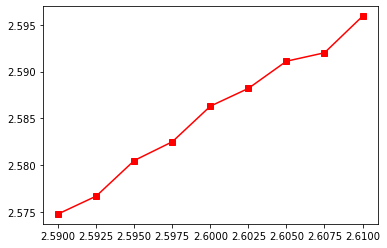

In [173]:
plt.plot(curr_list,act_curr,'r-s')

# Get current vs resonance freq

## near 5 GHz

In [175]:
import scipy.signal

In [18]:
clist=np.array([2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.4,5,\
               5.5,6,6.5,6.7,6.8,7.5])
flist=np.array([5.47e9,5.76e9,6.01e9,6.31e9,6.58e9,6.86e9,\
               7.14e9,7.41e9,7.69e9,7.97e9,8.80e9,9.50e9,\
               10.17e9,10.87e9,11.11e9,11.23e9,12.19e9])
ftn=np.poly1d(np.polyfit(clist,flist,4))

plt.plot(clist,flist,'ro')
newclist=np.linspace(2,10,10)
plt.plot(newclist,ftn(newclist))

## near 26 GHz

Text(0, 0.5, 'freq, ghz')

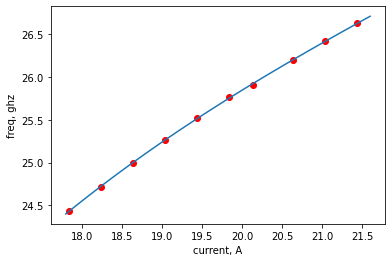

In [92]:
# og9-k2 : field vs freq map
xlist=np.array([21.44,21.04,20.64,20.14,19.84,19.44,19.04,18.64,18.24,17.84])
ylist=np.array([26.63,26.42,26.20,25.91,25.77,25.52,25.27,25.00,24.71,24.44])
plt.plot(xlist,ylist,'ro')

f=np.poly1d(np.polyfit(xlist,ylist,3))
newxlist=np.linspace(17.8,21.6,100)
plt.plot(newxlist,f(newxlist))

plt.xlabel('current, A')
plt.ylabel('freq, ghz')

# Microwave power

In [ ]:
scope=rm.open_resource("USB0::0x2A8D::0x3218::MY57120006::INSTR");time.sleep(1) # load U2002H power meter

In [42]:
scope.query('*IDN?')

'Keysight Technologies,U2002H,MY57120006,A1.04.01\n'

In [104]:
N=200
freqlist=np.linspace(4e9,5.5e9,N)
powerlist3=np.zeros(N)
scope.write('INIT:IMM')

for i,freq in enumerate(freqlist):
    change_freq(freq);time.sleep(0.1)
    scope.write('FETC?');time.sleep(0.1)
    powerlist3[i]=float(scope.read().split()[0])

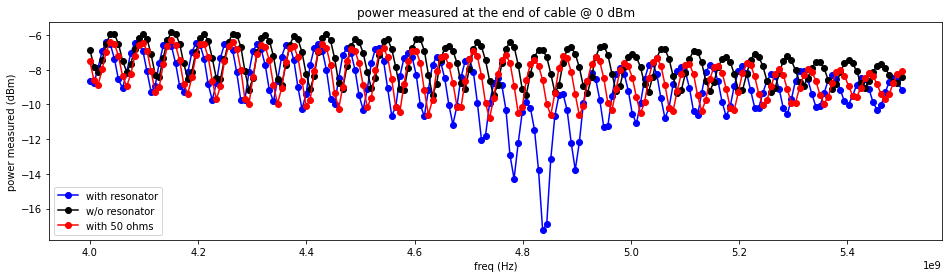

In [109]:
plt.figure(figsize=(16,4))
# plt.plot(freqlist,powerlist,'r-o',label='run1')
plt.plot(freqlist,powerlist,'b-o',label='with resonator')
plt.plot(freqlist,powerlist2,'k-o',label='w/o resonator')
plt.plot(freqlist,powerlist3,'r-o',label='with 50 ohms')
plt.title('power measured at the end of cable @ 0 dBm')
plt.xlabel('freq (Hz)')
plt.ylabel('power measured (dBm)')
plt.legend()

Text(0, 0.5, 'power measured (dBm)')

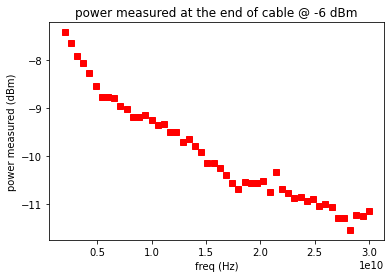

In [255]:
plt.plot(freqlist,powerlist,'rs')
plt.title('power measured at the end of cable @ -6 dBm')
plt.xlabel('freq (Hz)')
plt.ylabel('power measured (dBm)')

## loss in the microstrip : additional loss of -2 dBm over 20 GHz range

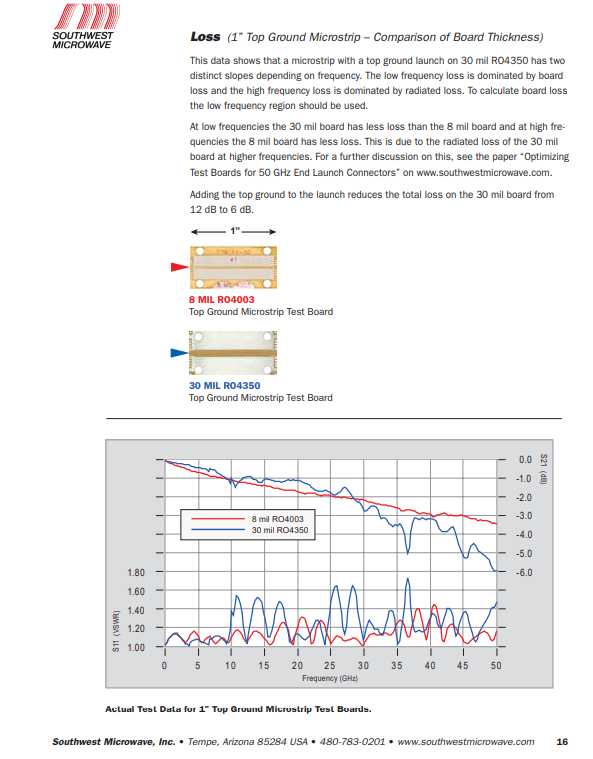

> One can give an additional +5 dBm/ 20 GHz corretion : 0.25 dBm increase correction per 1 GHz increase

# SSH protocol

In [ ]:
conFMR = paramiko.SSHClient() 
conFMR.set_missing_host_key_policy(paramiko.AutoAddPolicy())
conFMR.connect('192.168.0.4',username='KRISS_FMR',password='KRISSFMRsyss')

# Laser power

## Wrapper provided by Thorlabs

In [124]:
from ctypes import cdll,c_long, c_ulong, c_uint32,byref,create_string_buffer,c_bool,c_char_p,c_int,c_int16,c_double, sizeof, c_voidp
from TLPM import TLPM # TLPM.py is required

In [3]:
tlPM = TLPM()
deviceCount = c_uint32()
tlPM.findRsrc(byref(deviceCount))
print("devices found: " + str(deviceCount.value))

devices found: 1


In [16]:
tlPM.close()
resourceName = create_string_buffer(1024)
tlPM.getRsrcName(c_int(0), resourceName)
tlPM.open(resourceName, c_bool(True), c_bool(True))
power =  c_double()
tlPM.measPower(byref(power))
print(power)
tlPM.close()

c_double(0.0082748281)


0

In [46]:
%matplotlib inline

In [144]:
from matplotlib.animation import FuncAnimation
from itertools import count

In [ ]:
resourceName = create_string_buffer(1024)
tlPM.getRsrcName(c_int(0), resourceName)
tlPM.open(resourceName, c_bool(True), c_bool(True))
power =  c_double()
index=count()
xvals=[];
yvals=[];
def animate(i):
    xvals.append(next(index))
    tlPM.measPower(byref(power));time.sleep(0.2)
    yvals.append(1e3*float(power.value))
    plt.plot(xvals,yvals,'k-o')
    plt.xlabel('time')
    plt.ylabel('power (mW)')
ani=FuncAnimation(plt.gcf(),animate,interval=1000)

plt.show()

## Using resource manager

In [5]:
rm = pyvisa.ResourceManager();time.sleep(1)

In [711]:
thorlabsPM16=rm.open_resource("USB0::0x1313::0x807B::16041103::INSTR");time.sleep(1) # load U2002H power meter

In [6]:
thorlabsPM16.query('*IDN?')

'Thorlabs,PM16-130,16041103,1.2.0\n'

In [10]:
%matplotlib notebook

In [8]:
from matplotlib.animation import FuncAnimation
from itertools import count

<IPython.core.display.Javascript object>


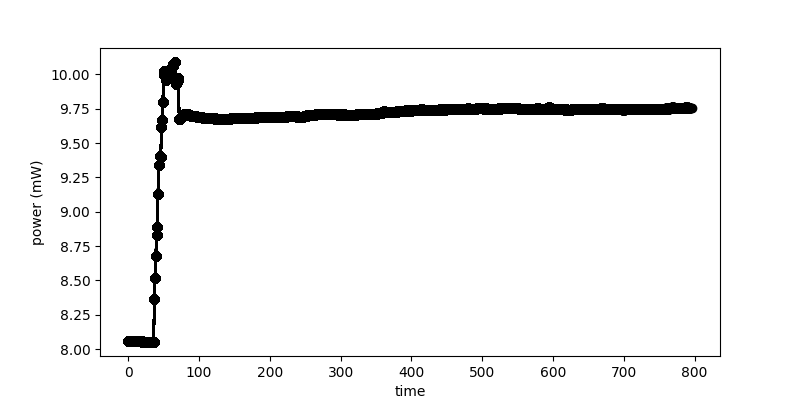

C:\Users\KRISS_BLS\AppData\Local\Temp\ipykernel_11932\587407034.py:14: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani=FuncAnimation(plt.gcf(),animate,interval=1000)
C:\Users\KRISS_BLS\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [11]:
plt.figure(figsize=(8,4))
index=count()
thorlabsPM16.write('CONF:POW') # change to power measure mode
thorlabsPM16.query('SENS:CORR:WAV?') # what is the wavelength?
xvals=[];
yvals=[];
def animate(i):
    xvals.append(next(index))
    thorlabsPM16.write('READ?');time.sleep(0.2)
    yvals.append(1e3*float(thorlabsPM16.read().split()[0]))
    plt.plot(xvals,yvals,'k-o')
    plt.xlabel('time')
    plt.ylabel('power (mW)')
ani=FuncAnimation(plt.gcf(),animate,interval=1000)
plt.show()

# Laser temperature

In [2]:
rm = pyvisa.ResourceManager();time.sleep(1)

In [11]:
Torus532 = rm.open_resource('ASRL6::INSTR',baud_rate=19200,write_termination = '\r\n',read_termination = '\r\n')

In [140]:
%matplotlib inline

In [135]:
from matplotlib.animation import FuncAnimation
from itertools import count

In [ ]:
index=count()
xvals=[];
yvals=[];
def animate(i):
    xvals.append(next(index))
    Torus532.write('LASTEMP?');time.sleep(0.2)
    yvals.append(float(Torus532.read().split('C')[0]))
    plt.plot(xvals,yvals,'k-o')
    plt.xlabel('time')
    plt.ylabel('temp (C)')
ani=FuncAnimation(plt.gcf(),animate,interval=1000)
plt.show()

# Teslameter

In [140]:
from lakeshore import Teslameter

# Connect to the first available Teslameter over USB
my_teslameter = Teslameter()

# Configure the instrument to be in DC field mode and give it a moment to settle
my_teslameter.command('SENSE:MODE DC')

# Query the probe serial number
probe_serial_number = my_teslameter.query('PROBE:SNUMBER?')

# Query the probe temperature
probe_temperature = my_teslameter.query('FETCH:TEMPERATURE?')

In [145]:
rm = pyvisa.ResourceManager();time.sleep(1)

In [31]:
f41=rm.open_resource('ASRL8::INSTR',baud_rate=115200,write_termination='\r\n',read_termination='\r\n');time.sleep(1) 

In [5]:
f41.query('*IDN?')

'Lake Shore,F41,LSA25ZA,1.2.2019030102'

In [ ]:
f41.query('*IDN?')
f41.query('PROBE:SNUMBER?')
f41.query('FETCh:DC?')

# Vertical field calibration

**Step to meter (Test with quartz substrate)**
- Z stage position move by negative = stage goes UP (-1 step = +23 nm)
- Z stage position move by positive = stage goes DOWN (+1 step = -30 nm)

**Step to field**
- +1 step = - 0.00062 mT at Hall sensor position (+1 step = -0.00080 mT at sample position)
- -1 step = + 0.00038 mT at Hall sensor position (-1 step = +0.00049 mT at sample position)

**Meter to field**
- By taking average 0.000023 mT/1 nm
- 500 um = 11.7 mT

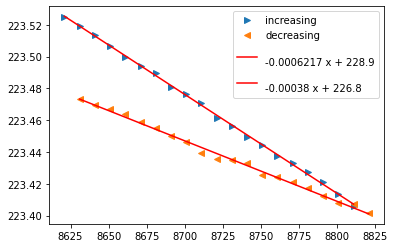

In [166]:
dataA_1s=np.loadtxt('outofplane_hfield_cal_220104_forward_1s.dat')
dataB_1s=np.loadtxt('outofplane_hfield_cal_220104_reverse_1s.dat')

plt.plot(dataA_1s[0],dataA_1s[1],'>',label='increasing ')
plt.plot(dataB_1s[0],dataB_1s[1],'<',label='decreasing')
ftn=np.poly1d(np.polyfit(dataA_1s[0],dataA_1s[1],1))
plt.plot(dataA_1s[0],ftn(dataA_1s[0]),'r',label=f'{ftn}')
ftn=np.poly1d(np.polyfit(dataB_1s[0],dataB_1s[1],1))
plt.plot(dataB_1s[0],ftn(dataB_1s[0]),'r',label=f'{ftn}')
plt.legend()

## Cal

In [50]:
stagez.get_position()

21276

In [139]:
N=20
hfs_list=np.zeros(N)
step=10
for i in range(N):
    step_list[i]=stagez.get_position()
#     print(f'Z-stage is now at {stagez.get_position()}.')
    hfs_list[i]=float(f41.query('FETCh:DC?'))*1e3 # in mT
    stagez.move_by(int(step))
    time.sleep(1)

In [140]:
np.savetxt('outofplane_hfield_cal_220104_forward_1s.dat',[step_list,hfs_list])

In [141]:
dataA_1s=np.loadtxt('outofplane_hfield_cal_220104_forward_1s.dat')

In [142]:
N=20
hfs_list=np.zeros(N)
step=10
for i in range(N):
    step_list[i]=stagez.get_position()
#     print(f'Z-stage is now at {stagez.get_position()}.')
    hfs_list[i]=float(f41.query('FETCh:DC?'))*1e3 # in mT
    stagez.move_by(int(-step))
    time.sleep(1)

In [143]:
np.savetxt('outofplane_hfield_cal_220104_reverse_1s.dat',[step_list,hfs_list])

In [144]:
dataB_1s=np.loadtxt('outofplane_hfield_cal_220104_reverse_1s.dat')

1.6360526315789472


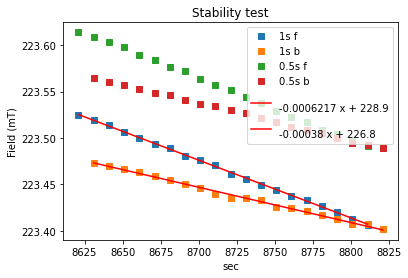

In [188]:
plt.title('Stability test')
plt.plot(dataA_1s[0],dataA_1s[1],'s',label='1s f')
plt.plot(dataB_1s[0],dataB_1s[1],'s',label='1s b')
plt.plot(dataA[0],dataA[1],'s',label='0.5s f')
plt.plot(dataB[0],dataB[1],'s',label='0.5s b')
# plt.plot(dataA3[0],dataA3[1],'-s',label='forward3')
# plt.plot(dataB3[0],dataB3[1],'-s',label='backward3')
plt.xlabel('sec')
plt.ylabel('Field (mT)')
plt.legend()
ftn=np.poly1d(np.polyfit(dataA_1s[0],dataA_1s[1],1))
plt.plot(dataA_1s[0],ftn(dataA_1s[0]),'r',label=f'{ftn}')
ftn=np.poly1d(np.polyfit(dataB_1s[0],dataB_1s[1],1))
plt.plot(dataB_1s[0],ftn(dataB_1s[0]),'r',label=f'{ftn}')
plt.legend()
print(0.0006217/0.00038)

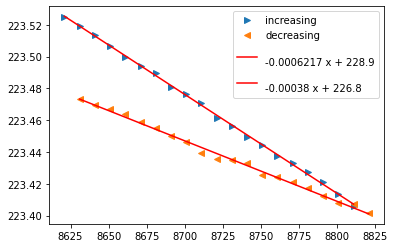

In [166]:
dataA_1s=np.loadtxt('outofplane_hfield_cal_220104_forward_1s.dat')
dataB_1s=np.loadtxt('outofplane_hfield_cal_220104_reverse_1s.dat')

plt.plot(dataA_1s[0],dataA_1s[1],'>',label='increasing ')
plt.plot(dataB_1s[0],dataB_1s[1],'<',label='decreasing')
ftn=np.poly1d(np.polyfit(dataA_1s[0],dataA_1s[1],1))
plt.plot(dataA_1s[0],ftn(dataA_1s[0]),'r',label=f'{ftn}')
ftn=np.poly1d(np.polyfit(dataB_1s[0],dataB_1s[1],1))
plt.plot(dataB_1s[0],ftn(dataB_1s[0]),'r',label=f'{ftn}')
plt.legend()

## Stability

In [54]:
N=6000
hfs_list2=np.zeros(N)
time_list2=np.zeros(N)
for i in range(N):
    hfs_list2[i]=float(f41.query('FETCh:DC?'))*1e3 # in mT
    time.sleep(0.1)
    time_list2[i]=0.1*i

In [55]:
np.savetxt('outofplane_hfield_stability_220104.dat',[time_list2,hfs_list2])

In [56]:
dataA=np.loadtxt('outofplane_hfield_stability_220104.dat')

Text(0, 0.5, 'Field (mT)')

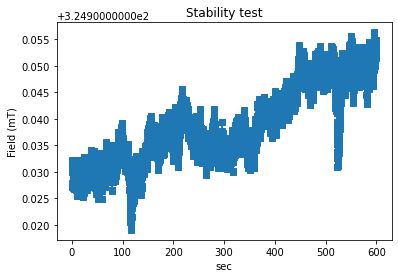

In [57]:
plt.title('Stability test')
plt.plot(dataA[0],dataA[1],'-s')
plt.xlabel('sec')
plt.ylabel('Field (mT)')

# Field calibration

In [25]:
rm = pyvisa.ResourceManager();time.sleep(1)
f41=rm.open_resource('ASRL8::INSTR',baud_rate=115200,write_termination='\r\n',read_termination='\r\n');time.sleep(1) 

In [10]:
float(f41.query('FETCh:DC?'))*1e3

-1.58919250321388

In [31]:
N=21
curr_list=np.linspace(-10,10,N)
np.savetxt('kepco_cal_a_atpole.dat',[curr_list,h_lista_kepco])
N=21
curr_list=np.linspace(10,-10,N)
np.savetxt('kepco_cal_b_atpole.dat',[curr_list,h_listb_kepco])

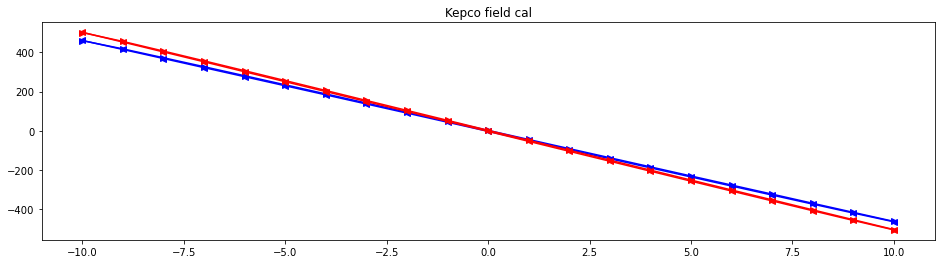

In [38]:
plt.figure(figsize=(16,4))
plt.title('Kepco field cal')
dataA=np.loadtxt('kepco_cal_a_center.dat')
plt.plot(dataA[0],dataA[1],'b->',label='wait time = 1 s forward')
dataA=np.loadtxt('kepco_cal_b_center.dat')
plt.plot(dataA[0],dataA[1],'b-<',label='wait time = 1 s forward')
dataA=np.loadtxt('kepco_cal_a_atpole.dat')
plt.plot(dataA[0],dataA[1],'r->',label='wait time = 1 s forward')
dataA=np.loadtxt('kepco_cal_b_atpole.dat')
plt.plot(dataA[0],dataA[1],'r-<',label='wait time = 1 s forward')

# Opencv

In [80]:
import cv2

## Take single shot picture

In [82]:
cap.release()
cv2.destroyAllWindows()

In [87]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
out = cv2.imwrite('capture.jpg', frame)
time.sleep(1)
cap.release()
cv2.destroyAllWindows()

## Continuous streaming

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('Camera Window', frame)
#     if cv2.waitKey(1) == ord('q'):
#         break
cap.release()
cv2.destroyAllWindows()

# Thorlabs Kinesis stage operation

In [12]:
ks.TLI_BuildDeviceList() #initialize
ks.TLI_GetDeviceListSize()

2

In [19]:
serialnox = c_char_p(bytes("26001408", "utf-8"))
serialnoy = c_char_p(bytes("26001463", "utf-8"))

In [20]:
ks.SCC_Open(serialnox)
ks.SCC_Open(serialnoy)

0

In [333]:
current_motor_posx = ks.SCC_GetPosition(serialnox)
print("Current position x:", current_motor_posx)
current_motor_posy = ks.SCC_GetPosition(serialnoy)
print("Current position y:", current_motor_posy)

Current position x: 10080168
Current position y: 10990926


In [334]:
step=-30000

In [335]:
ks.SCC_MoveToPosition(serialnox, current_motor_posx+step)

0

In [33]:
kcdc.CC_StopImmediate (serialnox)

2

# All stage control with pylablib (APT)

In [1]:
from pylablib.devices import Thorlabs

In [2]:
Thorlabs.list_kinesis_devices()

[('97101351', 'Kinesis Pz Motor Control'),
 ('26001463', 'Stepper Controller'),
 ('26001408', 'Stepper Controller')]

In [4]:
stage = Thorlabs.KinesisPiezoMotor("97101351")

In [5]:
stage.move_by(-50)

In [3]:
stagex = Thorlabs.KinesisMotor("26001463")

In [16]:
stagex.move_by(1000)

In [17]:
stagex.get_position()

-2143243

# Senis Hall sensor

In [4]:
import paramiko
import scp

In [186]:
conRPi=paramiko.SSHClient()
conRPi.set_missing_host_key_policy(paramiko.AutoAddPolicy())
conRPi.connect('192.168.0.22',port=22,username='pi',password='raspberry')

In [299]:
# Measure Field
def measureSenis():
    scp.SCPClient(conRPi.get_transport()).put('MeasureKM.py','/home/pi/software/threeDhall_sw');time.sleep(0.3)
    stdin,stdout,stderr=conRPi.exec_command('python3 /home/pi/software/threeDhall_sw/MeasureKM.py');time.sleep(1)
    scp.SCPClient(conRPi.get_transport()).get('/home/pi/software/threeDhall_sw/bzfield.dat')
    time.sleep(0.3)
    bx,by,bz,temphall=np.loadtxt('bzfield.dat')
    print(bx,by,bz,temphall)
    return bz

In [456]:
hzlist10=np.zeros(10)
for i in range(10):
    hzlist10[i]=measureSenis()
    print(i)

0
1
2
3
4
5
6
7
8
9


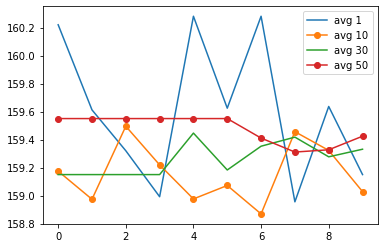

In [457]:
plt.plot(hzlist1,label='avg 1')
plt.plot(hzlist10,'o-',label='avg 10')
# plt.plot(hzlist20,label='avg 20')
plt.plot(hzlist30,label='avg 30')
plt.plot(hzlist50,'o-',label='avg 50')
plt.legend()

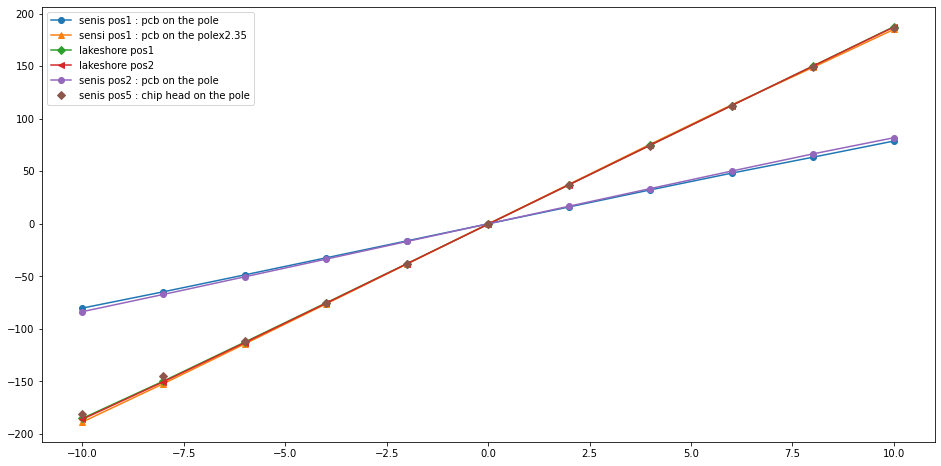

In [368]:
plt.figure(figsize=(16,8))
plt.plot(clist,hlist*1,'o-',label='senis pos1 : pcb on the pole')
plt.plot(clist,hlist*2.35,'^-',label='sensi pos1 : pcb on the polex2.35')
plt.plot(clist2,-hlist2,'D-',label='lakeshore pos1')
plt.plot(clist3,-hlist3,'<-',label='lakeshore pos2')
plt.plot(clist4,hlist4*1,'o-',label='senis pos2 : pcb on the pole')
# plt.plot(clist5,-hlist5,'-s',label='senis pos4 : chip head on the pole')
plt.plot(clist7,-hlist7,'D',label='senis pos5 : chip head on the pole')
plt.legend()

# Ghost test

In [37]:
ghost.write('override');time.sleep(3)

In [ ]:
for i in range(100):
    ghost.write('delete');time.sleep(0.1)
    print('starting scan number %i...'%1)
    ghost.write('start %i'%1);#time.sleep(90/100*BLScount)
    check_ghost_acquiring(1,1);time.sleep(0.1)
    ghost.write('stop');time.sleep(0.1)
    time.sleep(0.01)